<a href="https://colab.research.google.com/github/100car/examination/blob/main/diploma_v05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дипломна робота
## КОМП'ЮТЕРНА АКАДЕМІЯ IT STEP

![КОМП'ЮТЕРНА АКАДЕМІЯ IT STEP](https://raw.githubusercontent.com/100car/examination/main/logo_it_step.jpg)

**Курс:** Штучний інтелект з використанням Python

**Тема:** Інтелектуальна система аналізу та прогнозування продажів на основі неструктурованих Excel-звітів

**Група:** AI+Python52

**Викладач:** Галиш Антон

**Виконав:** Токар Сергій
## Мета роботи:
Розробка пайплайну для обробки "сирих" Excel-файлів, проведення розвідувального аналізу (EDA), сегментація товарів/клієнтів (Clustering) та побудова моделі прогнозування продажів (ML).

# Підготовка середовища Colab

Ідемо шляхом «тонкого» ноутбука: в ipynb-файлі тільки підготовка, конфігурація, запуск пайплайна і демонстрація результатів. Вся основна логіка в py-файлах репозиторію GitHub (так зручніше тестувати й підтримувати), усі складні і не дуже перетворення винесені в окремі модулі.

### Клонуємо репозиторій з кодом та даними

In [41]:
import os, sys, pathlib

REPO_URL = "https://github.com/100car/examination.git"
REPO_DIR = "examination"

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL}
%cd {REPO_DIR}

# (Опційно) завжди тягнемо останні зміни
!git pull --ff-only


Cloning into 'examination'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 206 (delta 92), reused 136 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (206/206), 1.60 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/examination/examination/examination
Already up to date.


### Структура даних пайплайну:
```
DATA/
├─ SKU/
│  └─ sku_master.xlsx                 # Головний файл з інформацією по SKU
└─ SALES/
   ├─ SALES_REPORTS/                  # Вхідні звіти продажів по регіонах
   ├─ RECOGNIZED_SALES_REPORTS/       # Розпізнані звіти (евристики + LLM)
   ├─ MONTHLY_SALES_CORRECTED/        # Скориговані користувачем медіани
   ├─ REGIONAL_ARRIVALS/              # Вхідні надходження по регіонах
   ├─ TRANSIT_PLANNED_ARRIVALS/       # Планові надходження на транзитні склади
   ├─ TRANSIT_PLANNED_SHIPMENTS/      # Планові відвантаження з транзитних складів
   ├─ TRANSIT_STOCK_STATUS/           # Статуси залишків на транзитних складах
   ├─ RESULT/                         # Вихідні результати пайплайна
   │  └─ results.xlsx                 # зберігатимуться у цьому файлі
   └─ LOGS/                           # Детальні логи виконання
```

Пайплайн передбачає, що всі модулі працюють із цією структурою. Зараз відбулося завантаження необхідних файлів даних у вигляді таблиць Excel, "шматки" пайтонівського коду, файл "вимог" та конфігурації.


### Встановлюємо вимоги (requirements.txt)



In [42]:
!pip -q install -r DATA/requirements.txt

### Налаштовуємо секретний ключ (для LLM-моделі)

In [43]:
# GEMINI_API_KEY збережено через Colab > Secrets
import os
try:
    from google.colab import userdata
    key = userdata.get("GEMINI_API_KEY")
    if key:
        os.environ["GEMINI_API_KEY"] = key
except Exception:
    pass

# Перевіримо, що ключ є (не друкуємо його!)
HAS_GEMINI_KEY = bool(os.environ.get("GEMINI_API_KEY"))
print("GEMINI_API_KEY set:", HAS_GEMINI_KEY)


GEMINI_API_KEY set: True


### Конфігурація пайплайна

Щоб не хардкодити шляхи / параметри в коді, використовуємо окремий конфіг-файл.
Нижче — завантаження `config.yaml` (або дефолтний конфіг, якщо файла ще нема).

#### Примітка:

Файл config.yaml підготовлений для подальшого винесення параметрів пайплайну,
але в межах поточної реалізації всі ключові шляхи і параметри поки що зафіксовані в коді.

In [44]:
# Конфіг: читаємо config.yaml + дефолти (deep-merge) + готуємо змінні/директорії
from pathlib import Path
import yaml
import os

CFG_PATH = Path("config.yaml")

default_cfg = {
    "paths": {
        "data_root": "DATA",
        "sku_master": "DATA/SKU/sku_master.xlsx",
        "sales_reports_dir": "DATA/SALES/SALES_REPORTS",
        "result_dir": "DATA/SALES/RESULT",
        "result_workbook": "DATA/SALES/RESULT/results.xlsx",
    },
    "pipeline": {
        "debug": True,
        "llm_enabled": True,
    }
}

def deep_merge(base: dict, override: dict) -> dict:
    """Рекурсивно зливає словники: override має пріоритет."""
    out = dict(base)
    for k, v in (override or {}).items():
        if isinstance(v, dict) and isinstance(out.get(k), dict):
            out[k] = deep_merge(out[k], v)
        else:
            out[k] = v
    return out

user_cfg = {}
if CFG_PATH.exists():
    user_cfg = yaml.safe_load(CFG_PATH.read_text(encoding="utf-8")) or {}

cfg = deep_merge(default_cfg, user_cfg)

# 1) Авто-вимкнення LLM, якщо ключа нема
# HAS_GEMINI_KEY береться з попередньої комірки з секретом; якщо її не було — підстрахуємось:
HAS_GEMINI_KEY = globals().get("HAS_GEMINI_KEY", bool(os.environ.get("GEMINI_API_KEY")))

if cfg["pipeline"].get("llm_enabled", False) and not HAS_GEMINI_KEY:
    cfg["pipeline"]["llm_enabled"] = False
    print("⚠️ GEMINI_API_KEY не задано — LLM вимкнено (pipeline.llm_enabled=False).")

# 2) Зручні змінні для наступних кроків ноутбука
DATA_ROOT = Path(cfg["paths"]["data_root"])
RESULT_DIR = Path(cfg["paths"]["result_dir"])
RESULT_XLSX = Path(cfg["paths"]["result_workbook"])

# 3) Гарантуємо, що папка під results.xlsx існує
RESULT_DIR.mkdir(parents=True, exist_ok=True)

# 4) Прокидуємо базові налаштування в env (щоб модулі могли читати, якщо захочеш)
os.environ["PIPELINE_DEBUG"] = "1" if cfg["pipeline"].get("debug") else "0"
os.environ["PIPELINE_LLM_ENABLED"] = "1" if cfg["pipeline"].get("llm_enabled") else "0"
os.environ["PIPELINE_RESULT_XLSX"] = str(RESULT_XLSX)

print("Config loaded ✅")
print("RESULT_XLSX =", RESULT_XLSX)
print("LLM enabled =", cfg["pipeline"]["llm_enabled"])

cfg


Config loaded ✅
RESULT_XLSX = DATA/SALES/RESULT/results.xlsx
LLM enabled = True


{'paths': {'data_root': 'DATA',
  'sku_master': 'DATA/SKU/sku_master.xlsx',
  'sales_reports_dir': 'DATA/SALES/SALES_REPORTS',
  'result_dir': 'DATA/SALES/RESULT',
  'result_workbook': 'DATA/SALES/RESULT/results.xlsx'},
 'pipeline': {'debug': True, 'llm_enabled': True}}

## STEP 01. Пакетний парсер Excel-звітів продажів по регіонам

Зчитуємо з папки
```
DATA/
└─ SALES/
   └─ SALES_REPORTS/                  
```
всі звіти продажів по регіонах (три: Україна, Узбекистан та Казахстан, - або менше). Якщо за допомогою евристичного аналізу не вдається розпізнати заголовки стовбчиків, то використовуємо LLM (Gemini API).
Важливі правила для обробки:
- Рядки без Symbol (артикула) НЕ переносимо у вихідний файл.
- Якщо у заголовках є "ОС" (після нормалізації -> "ос") — це Stock і регіон UZ визначається однозначно.
- Перед аналізом "розкриваємо" всі приховані колонки (hidden=False) і вже потім детектимо/рахуємо.
- TOTAL у вихідному файлі завжди перераховується як сума місяців.
Якщо у вхідному файлі був власний Total — підсвічуємо mismatch червоним.

In [45]:
!python DATA/build_results_workbook.py

STEP 1 | Build results workbook | 2026-02-01 20:33:52
OK   UA2025.xlsx                                              | det=H   | region=UA  | checked=1017 | mismatches=0    | saved=UA_UA2025_sales_recognized.xlsx
OK   25_12_30_Продажа_АМР_за_январь_декабрь_2025_г_.xls.xlsx  | det=H   | region=KZ  | checked=349  | mismatches=0    | saved=KZ_25_12_30_Продажа_АМР_за_январь_декабрь_2025_г_.xls_sales_recognized.xlsx
OK   amp monthly december.xlsx                                | det=LLM | region=UZ  | checked=598  | mismatches=0    | saved=UZ_amp monthly december_sales_recognized.xlsx
OK   | step=1 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx
Проаналізовано: 3 файлів | Сформовано: 3 файлів (із них за допомогою LLM: 1)
OK   | step=1 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx


## Результати першого етапу
У ході виконання модуля build_results_workbook сформовано зведений Excel-файл, що містить окремі аркуші зі звітами продаж по регіонам:
*   UA-sales (Україна))
*   UZ-sales (Узбекистан)
*   KZ-sales (Казахстан)

Кожен аркуш включає агреговані показники продажів відповідного регіону та використовується на наступних етапах обробки даних.

## STEP 02. Формування регіональних надходжень товарів

На цьому етапі виконується побудова допоміжних аркушів із регіональними надходженнями товарів
(UA+, KZ+, UZ+), які використовуються для подальшої нормалізації та розрахунку скоригованих
місячних продажів.

Скрипт `regional_arrivals.py` виконує такі дії:
- зчитує зведену таблицю результатів продажів;
- нормалізує товарні коди (SKU) з використанням довідника `sku_master.xlsx`;
- агрегує надходження за регіонами;
- додає до Excel-файлу нові аркуші з регіональними надходженнями.

Результатом виконання є розширений файл результатів, що містить регіональні дані,
необхідні для подальших етапів аналітики.

In [46]:
!python DATA/regional_arrivals.py

STEP 2 | Build regional arrivals sheets | 2026-02-01 20:34:04
OK   | region=UA | in=48    | unique=48    | merged=0     | green=0    | red=2    | saved=UA+ | file=05.01.2025 UA.xlsx
OK   | region=KZ | in=269   | unique=192   | merged=77    | green=4    | red=0    | saved=KZ+ | file=KZ-12+order.xlsx
OK   | region=UZ | in=103   | unique=101   | merged=2     | green=0    | red=0    | saved=UZ+ | file=UZ_amp 2025.xlsx
OK   | step=2 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx


## STEP 03. Нормалізація результатів та уніфікація місячних показників

На цьому етапі виконується фінальна нормалізація зведеного файлу результатів продажів.
Скрипт `normalize_results_workbook.py` приводить дані до єдиного формату,
придатного для подальшого аналізу та використання в моделях машинного навчання.

Основні дії скрипта:
- уніфікація назв місяців до стандартного формату  
  (`янв`, `фев`, `мар`, `апр`, `май`, `июн`, `июл`, `авг`, `сен`, `окт`, `ноя`, `дек`);
- нормалізація товарних ідентифікаторів (`Symbol_normalized`);
- застосування місячних корекцій продажів (за наявності файлів корекцій);
- розрахунок скоригованих показників продажів;
- формування фінальних аркушів `*-normalized`.

Отримані таблиці представляють собою стандартизовані часові ряди,
готові для статистичного аналізу, кластеризації та прогнозування попиту.


In [47]:
!python DATA/normalize_results_workbook.py --include-arrivals-added-col

STEP 3 | Normalize results workbook | 2026-02-01 20:34:06
OK   | region=UA | in=1017  | unique=1017  | merged=0     | green=0    | red=25   | arrivals_added=46   | saved=UA-normalized
OK   | region=KZ | in=349   | unique=345   | merged=4     | green=24   | red=0    | arrivals_added=172  | saved=KZ-normalized
OK   | region=UZ | in=598   | unique=597   | merged=1     | green=5    | red=0    | arrivals_added=98   | saved=UZ-normalized
OK   | step=3 | corrections_file=кольца results (2).xlsx
OK   | region=UA | corrections=696   | applied=696   | changed=175   | not_found=0    
OK   | region=KZ | corrections=345   | applied=345   | changed=69    | not_found=0    
OK   | region=UZ | corrections=597   | applied=597   | changed=120   | not_found=0    
OK   | step=3 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx


## Вітрина “До замовлення” (плановий горизонт = 6 місяців)

Оцінка дефіциту виконується на горизонті **6 місяців**:
- очікуваний попит = `Mediana × 6`;
- дефіцит = `Need_6m = max(0, Mediana × 6 − Stock)`;
- покриття запасом = `Coverage_6m = Stock / (Mediana × 6)`.

Вивід на екран TOP (`=7`) позицій окремо для кожного регіону.
Це дає швидкий список товарів, які потрібно замовляти першочергово, показує структуру отриманих аркушів `*-normalized`.


In [48]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

TOP_N = 7            # <-- кількість ТОП товарних позицій по регіону
HORIZON_MONTHS = 6   # <-- головна константа горизонту

result_xlsx = Path(os.environ.get("PIPELINE_RESULT_XLSX", "DATA/SALES/RESULT/results.xlsx"))
assert result_xlsx.exists(), f"Results file not found: {result_xlsx}"

xls = pd.ExcelFile(result_xlsx)
NORMALIZED_SHEETS = [s for s in xls.sheet_names if s.lower().endswith("normalized")]
assert NORMALIZED_SHEETS, "Не знайдено жодного *-normalized аркуша"

print("Використовуються аркуші:", NORMALIZED_SHEETS)

def load_region(sheet_name: str) -> pd.DataFrame:
    df = pd.read_excel(result_xlsx, sheet_name=sheet_name, engine="openpyxl")

    # базові перевірки
    if "Symbol_normalized" not in df.columns:
        raise ValueError(f"[{sheet_name}] немає Symbol_normalized")

    df["Symbol_normalized"] = df["Symbol_normalized"].astype(str).str.strip()
    df = df[df["Symbol_normalized"].str.startswith("PR-")].copy()

    # Mediana (обов'язкова для цього підходу)
    if "Mediana" not in df.columns:
        raise ValueError(f"[{sheet_name}] немає колонки Mediana (потрібна для горизонту {HORIZON_MONTHS}m)")
    df["Mediana"] = pd.to_numeric(df["Mediana"], errors="coerce").fillna(0.0)

    # Stock
    df["Stock"] = pd.to_numeric(df.get("Stock", 0), errors="coerce").fillna(0.0)

    # Demand на горизонт
    df["Demand_h"] = df["Mediana"] * HORIZON_MONTHS

    # Need на горизонт
    df["Need_h"] = (df["Demand_h"] - df["Stock"]).clip(lower=0)

    # Coverage на горизонт
    df["Coverage_h"] = np.where(df["Demand_h"] > 0, df["Stock"] / df["Demand_h"], np.nan)

    region = sheet_name.split("-")[0].split("_")[0]
    df["Region"] = region

    return df[["Region","Symbol_normalized","Mediana","Stock","Demand_h","Need_h","Coverage_h"]]

def style_clean(df: pd.DataFrame):
    return (df.style
        .format({
            "Mediana":"{:.1f}",
            "Stock":"{:.0f}",
            "Demand_h":"{:.0f}",
            "Need_h":"{:.0f}",
            "Coverage_h":"{:.0%}",
        }, na_rep="")
        .set_properties(subset=["Symbol_normalized"], **{
            "min-width":"300px",
            "white-space":"nowrap",
            "font-weight":"600"
        })
        .set_properties(subset=["Need_h"], **{"font-weight":"700"})
        .set_table_styles([
            {"selector":"th", "props":[("text-align","center")]},
            {"selector":"td", "props":[("text-align","right"), ("padding","4px 8px")]},
        ])
    )

# --- Вивід по кожному регіону ---
for sheet in NORMALIZED_SHEETS:
    df = load_region(sheet)
    region = df["Region"].iloc[0]

    top = (df
        .sort_values(["Need_h","Demand_h"], ascending=[False, False])
        .head(TOP_N)
        .reset_index(drop=True)
    )

    print(f"\n📦 {region} | TOP-{TOP_N} до замовлення (горизонт={HORIZON_MONTHS}м)")
    display(style_clean(top))


Використовуються аркуші: ['UA-normalized', 'KZ-normalized', 'UZ-normalized']

📦 UA | TOP-7 до замовлення (горизонт=6м)


,Region,Symbol_normalized,Mediana,Stock,Demand_h,Need_h,Coverage_h
0,UA,PR-DAE-49-3548-000-SET,141.5,531,849,318,63%
1,UA,PR-LAD-44-2804-000-SET,119.0,443,714,271,62%
2,UA,PR-LAD-44-2804-040-SET,111.5,502,669,167,75%
3,UA,PR-DAE-49-3548-050-SET,62.5,217,375,158,58%
4,UA,PR-TAV-44-4120-000-SET,49.0,141,294,153,48%
5,UA,PR-LAD-44-2802-040-SET,69.0,263,414,151,64%
6,UA,PR-SEN-44-4125-000-SET,76.5,313,459,146,68%



📦 KZ | TOP-7 до замовлення (горизонт=6м)


,Region,Symbol_normalized,Mediana,Stock,Demand_h,Need_h,Coverage_h
0,KZ,PR-LAD-44-2804-040-SET,349.0,1364,2094,730,65%
1,KZ,PR-LAD-49-2805-050-SET,308.5,1526,1851,325,82%
2,KZ,PR-LAD-44-2804-000-SET,283.0,1397,1698,301,82%
3,KZ,PR-LAD-44-2804-080-SET,119.5,559,717,158,78%
4,KZ,PR-LAD-48-2805-000-SET,187.5,977,1125,148,87%
5,KZ,PR-LAD-49-2804-080-SET,49.0,217,294,77,74%
6,KZ,PR-LAD-44-2803-040-SET,57.5,270,345,75,78%



📦 UZ | TOP-7 до замовлення (горизонт=6м)


,Region,Symbol_normalized,Mediana,Stock,Demand_h,Need_h,Coverage_h
0,UZ,PR-DAE-39-1401-000-SET,5053.5,16476,30321,13845,54%
1,UZ,PR-DAE-39-1401-050-SET,4191.0,12385,25146,12761,49%
2,UZ,PR-DAE-39-1401-025-SET,2850.5,8289,17103,8814,48%
3,UZ,PR-DAE-49-3548-000-SET,1535.0,4203,9210,5007,46%
4,UZ,PR-DAE-49-3548-050-SET,1061.5,2748,6369,3621,43%
5,UZ,PR-DAE-49-3538-000-SET,1089.5,2961,6537,3576,45%
6,UZ,PR-DAE-49-3548-025-SET,932.0,3073,5592,2519,55%


## STEP 04. Planned Shipments → лист `STOCKS-`

Скрипт читає 0..3 Excel-файли з `DATA/SALES/TRANSIT_PLANNED_SHIPMENTS`,
агрегує кількість по SKU, нормалізує артикули та (за наявності) валідуює їх через `DATA/SKU/sku_master.xlsx`.

Результат: створює або перезаписує лист **`STOCKS-`** у `DATA/SALES/RESULT/results.xlsx`
з колонками: `Symbol_raw | Symbol | Quantity`.

Розфарбовування:
- валідний SKU → без заливки
- виправлено через Mapping → зелений
- все ще невалідний → червоний

In [49]:
!python DATA/transit_planned_shipments.py

STEP 4 | Build planned shipments sheet (STOCKS-) | 2026-02-01 20:34:20
OK   | file=05.01.2025 UA.xlsx             | in=48    | unique=48    | merged=0     | green=0    | red=2    | saved=STOCKS-
OK   | file=KZ.xlsx                        | in=138   | unique=138   | merged=0     | green=4    | red=0    | saved=STOCKS-
OK   | step=4 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx


## STEP 05. Побудова аркушу `RINGS_SUMMARY`

Скрипт будує лист **`RINGS_SUMMARY`** у `results.xlsx` на базі `SKU/sku_master.xlsx` (рядки `Name == 1`),
а далі підтягує транзитні залишки/сировину/планові приходи з папок у `DATA/SALES/`.

Наприкінці додає колонки:
- `Order_1`, `Order_2`, `Order_3` (порожні для ручного вводу)
- `Total Available` (формула суми всіх “даних” колонок зліва)

In [50]:
!python DATA/rings_summary.py

STEP 5a | Побудова RINGS_SUMMARY | 2026-02-01 20:34:22
OK | step=5a | sheet=RINGS_SUMMARY | rows=247 | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx
STEP 5b | Заповнення з sets + перевірка сум (5c) | 2026-02-01 20:34:24
WRN | step=5b | sheet=Товары на складе | skipped | Лист 'Товары на складе': не знайдено колонки SKU/Quantity
OK | step=5b | saved=/content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx | mapped_total=0 | missing_total=0
STEP 5d | Заповнення з surowce + перевірка в units | 2026-02-01 20:34:26
OK | step=5d | sheet=LWC+PE               | groups=58   | filled=59   | mapped=0   | missing=0   | split=1  | sum_min_units=  735084 | sum_results_units=  735084 | diff_units=       0
OK | step=5d | sheet=Monika               | groups=20   | filled=20   | mapped=0   | missing=0   | split=0  | sum_min_units=   26112 | sum_results_units=   26112 | diff_units=       0
OK | step=5e | sheet=STOCKS- (results) | in=60     | filled=60

## STEP 06. Прогноз дефіциту поршневих кілець (Excel формули) → NEED_M1..NEED_M30

На цьому етапі додається прогноз дефіциту поршневих кілець на N місяців вперед
у вигляді **формул Excel** без “жорстких” чисел.

Перевага такого підходу:
- при зміні `Month_sales` або `Stock` на листах `UA-normalized / KZ-normalized / UZ-normalized`
  прогноз у `RINGS_SUMMARY` перераховується автоматично.

Логіка для кожного регіону і місяця `m`:
- `deficit = m * Month_sales - Stock`
- `need_region_m = IF(deficit > 0, -deficit, 0)`

Потім враховується загальний ресурс:
- `need_total_m = MIN(0, TotalAvailable + need_UA_m + need_KZ_m + need_UZ_m)`

Інтерпретація:
- `0` → дефіциту немає
- `< 0` → дефіцит (скільки не вистачає)

Додатково застосовується умовне форматування: значення `< 0` підсвічуються червоним.


In [51]:
!python DATA/rings_forecast_excel.py --months 30


STEP 8 | Прогноз наявності поршневих кілець | months=30
OK | updated: /content/examination/examination/examination/DATA/SALES/RESULT/results.xlsx | forecast_months=30


## Фінальний результат: лист `RINGS_SUMMARY` (що отримуємо в результаті)

Нижче наведено перші 10 рядків фінального файлу `results.xlsx`, у яких потреба з горизонтом 6 мвсяців найбільша.
Таблиця містить **обчислені в Excel** показники доступності та прогнозу дефіциту, може безпосередньо використовуватись для прийняття рішень щодо замовлення товарів.



In [52]:
import pandas as pd
import numpy as np
from pathlib import Path

results_path = Path("DATA/SALES/results-final.xlsx")

df = pd.read_excel(results_path, sheet_name="RINGS_SUMMARY", engine="openpyxl")

# NaN -> пусто для відображення, але для сортування NEED_M6 треба число
df = df.replace({np.nan: ""})

assert "NEED_M6" in df.columns, "У листі RINGS_SUMMARY немає колонки NEED_M6"

# зробимо числову копію для сортування (пусті -> +inf, щоб пішли в кінець)
need_num = pd.to_numeric(df["NEED_M6"], errors="coerce")
df["_NEED_M6_num"] = need_num.fillna(np.inf)

# беремо 10 з мінімальним NEED_M6
df10 = (df.sort_values("_NEED_M6_num", ascending=True)
          .drop(columns=["_NEED_M6_num"])
          .head(10)
          .copy())

# підберемо колонки для вітрини: Symbol + Total_available (якщо є) + NEED_M*
need_cols = [c for c in df10.columns if isinstance(c, str) and c.startswith("NEED_M")]
need_cols_sorted = sorted(need_cols, key=lambda x: int(x.split("_M")[-1]) if x.split("_M")[-1].isdigit() else 10**9)

left_cols = []
for c in ["Symbol", "Total_available", "TOTAL", "Stock"]:
    if c in df10.columns:
        left_cols.append(c)
if "Symbol" not in left_cols and "Symbol" in df10.columns:
    left_cols = ["Symbol"]

df_view = df10[left_cols + need_cols_sorted].copy()

# стиль (як у твоїй “ок” версії)
sty = (df_view.style
    .hide(axis="index")
    .set_properties(subset=["Symbol"] if "Symbol" in df_view.columns else [], **{
        "min-width":"340px",
        "max-width":"340px",
        "white-space":"nowrap",
        "font-weight":"600"
    })
    .format(na_rep="", precision=0)
    .set_table_styles([
        {"selector":"th", "props":[("white-space","nowrap"), ("min-width","70px")]},
        {"selector":"td", "props":[("padding","4px 8px"), ("text-align","right")]},
    ])
)

display(sty)


Symbol,NEED_M1,NEED_M2,NEED_M3,NEED_M4,NEED_M5,NEED_M6,NEED_M7,NEED_M8,NEED_M9,NEED_M10,NEED_M11,NEED_M12,NEED_M13,NEED_M14,NEED_M15,NEED_M16,NEED_M17,NEED_M18,NEED_M19,NEED_M20,NEED_M21,NEED_M22,NEED_M23,NEED_M24,NEED_M25,NEED_M26,NEED_M27,NEED_M28,NEED_M29,NEED_M30
PR-DAE-49-1402-050-SET,0,0,-12,-252,-492,-732,-972,-1212,-1452,-1692,-1932,-2172,-2412,-2652,-2892,-3132,-3372,-3612,-3852,-4092,-4332,-4572,-4812,-5052,-5292,-5532,-5772,-6012,-6252,-6492
PR-DAE-39-1401-025-SET,0,0,0,0,0,-716,-3770,-6824,-9880,-12935,-15990,-19046,-22102,-25157,-28212,-31268,-34324,-37379,-40434,-43490,-46546,-49601,-52656,-55712,-58768,-61823,-64878,-67934,-70990,-74045
PR-DAE-49-3538-075-SET,0,0,-150,-300,-450,-600,-750,-900,-1050,-1200,-1350,-1500,-1650,-1800,-1950,-2102,-2254,-2405,-2556,-2708,-2860,-3011,-3162,-3314,-3466,-3617,-3768,-3920,-4072,-4223
PR-DAE-49-1402-025-SET,0,0,0,-91,-253,-415,-577,-739,-901,-1063,-1225,-1387,-1549,-1711,-1873,-2035,-2197,-2359,-2521,-2683,-2845,-3007,-3169,-3331,-3493,-3656,-3818,-3980,-4142,-4304
PR-LAD-49-2804-000-SET,-206,-212,-218,-224,-240,-373,-506,-639,-772,-905,-1038,-1171,-1304,-1437,-1570,-1703,-1836,-1969,-2102,-2235,-2368,-2501,-2634,-2767,-2900,-3033,-3166,-3299,-3432,-3565
PR-RAV-49-5901-000-SET,0,0,0,-23,-155,-287,-419,-551,-683,-815,-947,-1079,-1211,-1343,-1475,-1607,-1739,-1871,-2003,-2135,-2267,-2399,-2531,-2663,-2795,-2927,-3059,-3191,-3323,-3455
PR-LAD-49-2805-100-SET,-250,-250,-250,-250,-250,-275,-405,-535,-668,-810,-952,-1094,-1236,-1378,-1520,-1662,-1804,-1946,-2088,-2230,-2372,-2514,-2656,-2798,-2940,-3082,-3224,-3366,-3508,-3650
PR-LAD-47-2805-000-SET,-200,-200,-200,-200,-202,-260,-325,-391,-457,-524,-593,-661,-730,-798,-867,-936,-1004,-1073,-1141,-1210,-1279,-1347,-1416,-1484,-1553,-1622,-1690,-1759,-1827,-1896
PR-WOL-44-5650-100-SET,0,0,0,-19,-133,-252,-373,-500,-628,-755,-882,-1010,-1137,-1265,-1392,-1519,-1647,-1774,-1902,-2029,-2156,-2284,-2411,-2539,-2666,-2793,-2921,-3048,-3176,-3303
PR-WOL-44-5650-000-SET,0,0,0,0,-48,-247,-468,-688,-908,-1129,-1350,-1570,-1790,-2011,-2232,-2452,-2672,-2893,-3114,-3334,-3554,-3775,-3996,-4216,-4436,-4657,-4878,-5098,-5318,-5539


## STEP 07. EDA для "нормалізованих" аркушів (кільця поршневі: SKU з заданим префіксом `PR-`)

Мета: виконати EDA-аналіз для нормалізованих продажів по регіонах.

Робимо:
- читаємо всі аркуші `*-normalized` (UA/KZ/UZ)
- відбираємо SKU за префіксами з `config.yaml` (`filters.include_prefixes`, за замовчуванням `["PR-"]`)
- формуємо датасет у “довгому форматі” (region, Symbol_normalized, month, value)
- рахуємо агрегатні статистики
- будуємо графіки: гістограми та “ящики з вусами” (boxplot)

Артефакти зберігаються у `DATA/EDA/`:
- `normalized_long.csv`
- `normalized_summary_by_region.csv`
- `symbols_included_<REGION>.csv`, `symbols_excluded_<REGION>.csv`
- `plots/*.png`


STEP 7 | EDA (*-normalized) | long-format + агрегати + графіки


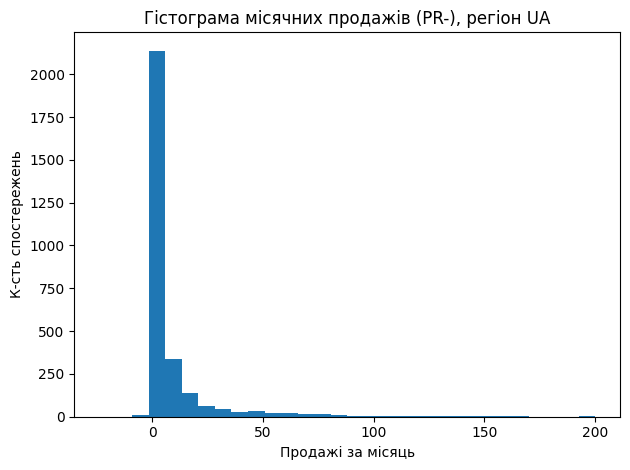

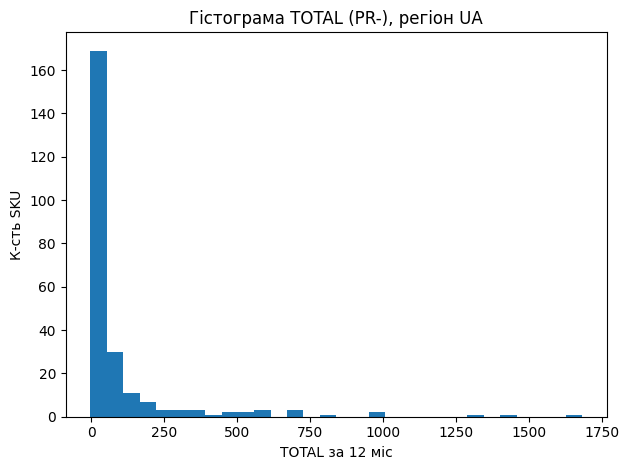

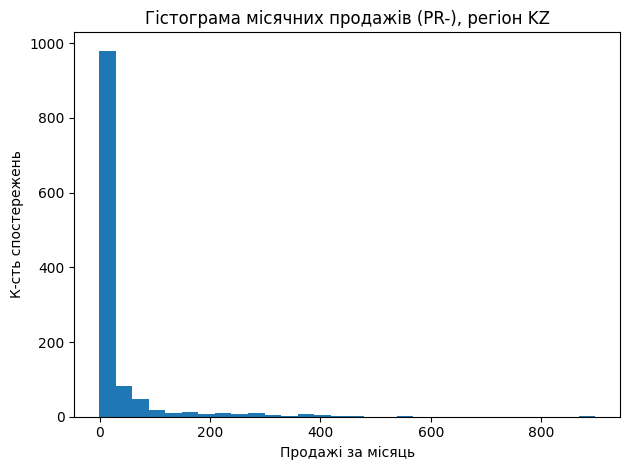

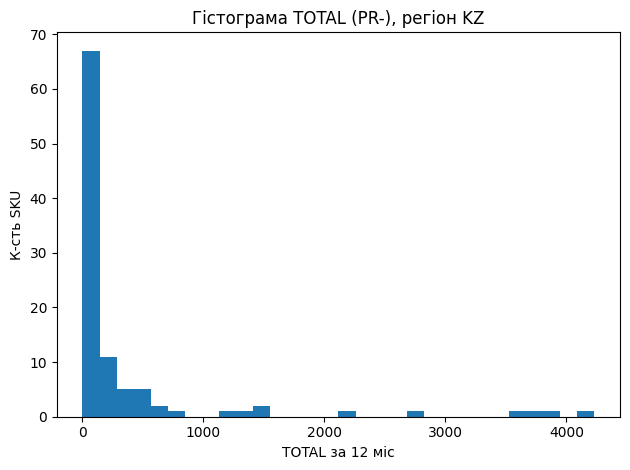

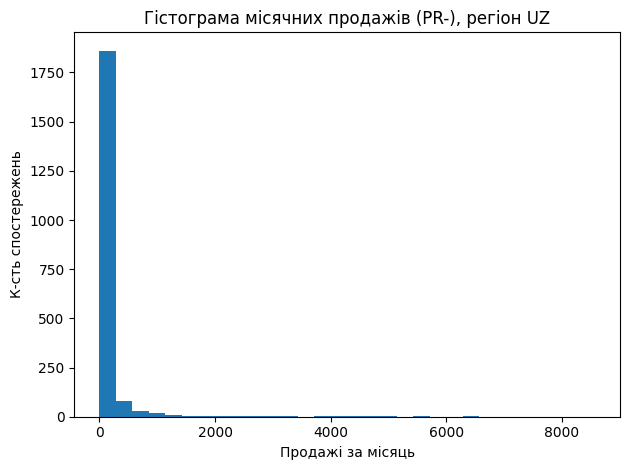

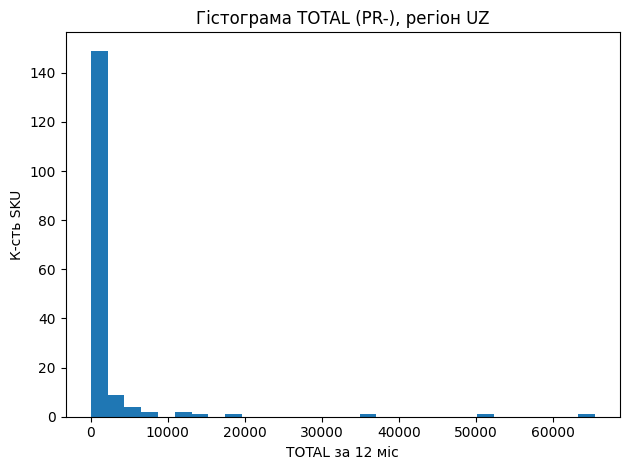

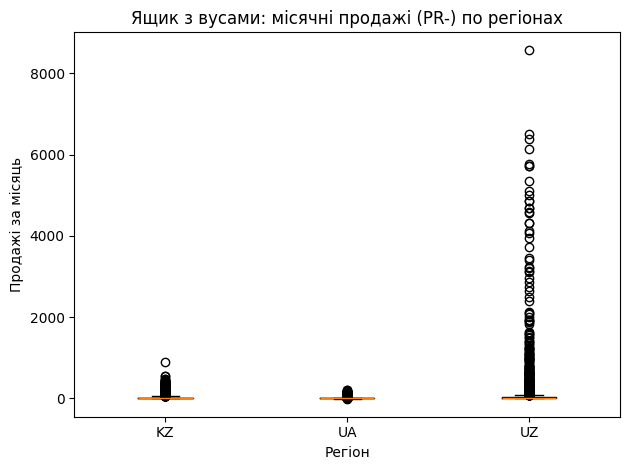

OK | STEP 7 завершено
- long:      DATA/EDA/normalized_long.csv
- summary:   DATA/EDA/normalized_summary_by_region.csv
- plots:     DATA/EDA/plots


<Figure size 640x480 with 0 Axes>

In [53]:
%run DATA/step07_eda_normalized.py

## STEP 08. Аналіз одного SKU по регіонах

Мета: на прикладі одного SKU показати різницю продажів між регіонами UA/KZ/UZ.

Шукаємо PR-SKU, яке одночасно: kz ∈ low і при цьому в UA/UZ воно “контрастне”: або ua=high і uz=mid / або ua=mid і uz=high

Вибір серед кандидатів: беремо те SKU, у якого TOTAL в KZ (low-регіон) найбільший. Якщо таких SKU нема — система не падає, бере з YAML

max_pr_total_by_region = {'ua': 1682.0, 'kz': 4232.0, 'uz': 65452.0}

✅ Обрано показовий SKU: PR-DAE-49-3548-000-SET
Причина: Автовибір: kz_low, ua_high, uz_mid; KZ_TOTAL=210


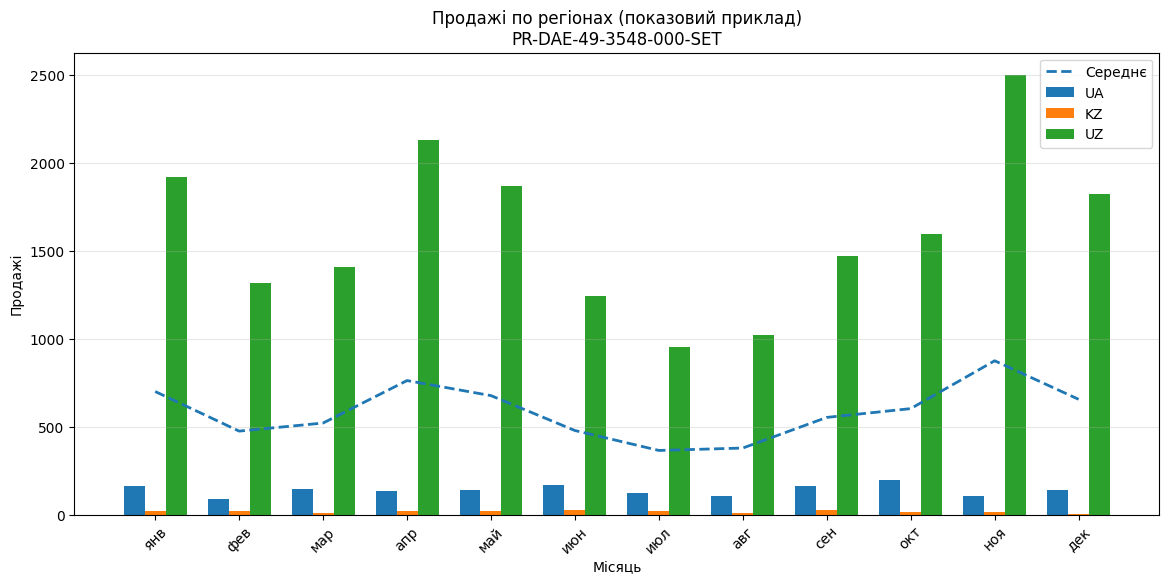

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

results_path = Path("DATA/SALES/RESULT/results.xlsx")
CFG_PATH = Path("config.yaml")

MONTHS = ["янв","фев","мар","апр","май","июн","июл","авг","сен","окт","ноя","дек"]

REGIONS = ["UA", "KZ", "UZ"]

def load_region_totals(region: str) -> pd.DataFrame:
    df = pd.read_excel(results_path, sheet_name=f"{region}-normalized", engine="openpyxl")

    key = "Symbol_normalized" if "Symbol_normalized" in df.columns else "Symbol"
    df = df.rename(columns={key: "SKU"}).copy()
    df["SKU"] = df["SKU"].astype(str).str.strip()

    # тільки PR-
    df = df[df["SKU"].str.startswith("PR-")].copy()

    # TOTAL
    if "TOTAL" in df.columns:
        df["TOTAL"] = pd.to_numeric(df["TOTAL"], errors="coerce").fillna(0.0)
    else:
        # якщо TOTAL нема — рахуємо з місяців
        for m in MONTHS:
            df[m] = pd.to_numeric(df.get(m, 0), errors="coerce").fillna(0.0)
        df["TOTAL"] = df[MONTHS].sum(axis=1)

    return df[["SKU", "TOTAL"]]

# --- 1) Збираємо TOTAL по регіонах ---
totals = {}
max_pr_total_by_region = {}

for r in REGIONS:
    t = load_region_totals(r)
    totals[r] = t
    max_pr_total_by_region[r.lower()] = float(t["TOTAL"].max()) if not t.empty else 0.0

print("max_pr_total_by_region =", max_pr_total_by_region)

# --- 2) 9 множин high/mid/low ---
sales = {k.lower(): {"high": set(), "mid": set(), "low": set()} for k in REGIONS}

def bucket(total: float, mx: float) -> str:
    if mx <= 0:
        return "low"
    share = total / mx
    if share >= 0.75:
        return "high"
    if share >= 0.25:
        return "mid"
    return "low"

# зробимо швидкий словник sku->total по кожному регіону
tot_map = {}
for r in REGIONS:
    tot_map[r.lower()] = dict(zip(totals[r]["SKU"], totals[r]["TOTAL"]))

# наповнюємо множини
for r in REGIONS:
    rl = r.lower()
    mx = max_pr_total_by_region[rl]
    for sku, total in tot_map[rl].items():
        sales[rl][bucket(float(total), mx)].add(sku)

# --- 3) кандидати: KZ low + ua high/mid  OR  ua low + uz high/mid, найбільше
def find_candidates():
    candidates = []

    # кандидати мають бути в KZ-low
    kz_low = sales["kz"]["low"]

    # варіант А: UA=high, UZ=mid
    a = kz_low & sales["ua"]["high"] & sales["uz"]["mid"]
    for sku in a:
        kz_total = float(tot_map["kz"].get(sku, 0.0))
        candidates.append((sku, "kz_low", "ua_high", "uz_mid", kz_total))

    # варіант Б: UA=mid, UZ=high
    b = kz_low & sales["ua"]["mid"] & sales["uz"]["high"]
    for sku in b:
        kz_total = float(tot_map["kz"].get(sku, 0.0))
        candidates.append((sku, "kz_low", "ua_mid", "uz_high", kz_total))

    return candidates


cands = find_candidates()

# --- 4) Вибір “найкращого”: той, у кого low TOTAL найбільший (найпоказовіший серед low)
if cands:
    # сортуємо за kz_total (найбільший — найпоказовіший у low)
    cands.sort(key=lambda x: x[4], reverse=True)
    best_sku, kz_tag, ua_tag, uz_tag, kz_total = cands[0]
    reason = f"Автовибір: {kz_tag}, {ua_tag}, {uz_tag}; KZ_TOTAL={kz_total:.0f}"
else:
    # fallback на YAML
    best_sku = None
    if CFG_PATH.exists():
        with open(CFG_PATH, "r", encoding="utf-8") as f:
            cfg = yaml.safe_load(f) or {}
        best_sku = ((cfg.get("analysis") or {}).get("sku_example")) or None

    if not best_sku:
        best_sku = "PR-DAE-47-3538-000-SET"

    reason = "Fallback: не знайдено SKU з KZ=low та (UA/UZ=high+mid) → беремо analysis.sku_example"

print("\n✅ Обрано показовий SKU:", best_sku)
print("Причина:", reason)

# --- 5) Тепер малюємо “гарний” графік по 3 регіонах для best_sku ---
def load_months(region: str, sku: str) -> np.ndarray:
    df = pd.read_excel(results_path, sheet_name=f"{region}-normalized", engine="openpyxl")
    key = "Symbol_normalized" if "Symbol_normalized" in df.columns else "Symbol"
    df = df.rename(columns={key: "SKU"}).copy()
    df["SKU"] = df["SKU"].astype(str).str.strip()
    row = df[df["SKU"] == sku]
    if row.empty:
        return np.zeros(12, dtype=float)
    row = row.iloc[0]
    vals = []
    for m in MONTHS:
        vals.append(float(pd.to_numeric(row.get(m, 0), errors="coerce") or 0))
    return np.array(vals, dtype=float)

ua_y = load_months("UA", best_sku)
kz_y = load_months("KZ", best_sku)
uz_y = load_months("UZ", best_sku)
mean_y = np.mean([ua_y, kz_y, uz_y], axis=0)

x = np.arange(len(MONTHS))
w = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - w, ua_y, width=w, label="UA")
plt.bar(x,     kz_y, width=w, label="KZ")
plt.bar(x + w, uz_y, width=w, label="UZ")

plt.plot(x, mean_y, linestyle="--", linewidth=2, label="Середнє")

plt.xticks(x, MONTHS, rotation=45)
plt.ylabel("Продажі")
plt.xlabel("Місяць")
plt.title(f"Продажі по регіонах (показовий приклад)\n{best_sku}")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.show()

# %run DATA/step08_sku_region_analysis.py


# Висновок (аналіз одного SKU PR-DAE-49-3548-000-SET по регіонах)
### UZ (Узбекистан)

Продажі стабільно та суттєво вищі за інші регіони протягом усього року. Спостерігається чітка сезонність із піками у квітні, листопаді та грудні. Саме регіон UZ визначає основний вклад у середнє значення продажів (пунктирна лінія).

### UA (Україна)

Продажі знаходяться на середньому рівні, значно нижчі за UZ, але істотно вищі за KZ. Динаміка відносно рівна, з помірним зростанням у жовтні–листопаді, що може вказувати на сезонний попит.

### KZ (Казахстан)

Продажі мінімальні впродовж усього періоду, практично на порядки нижчі за UZ. SKU знаходиться в зоні low-demand, що робить його кандидатом на перегляд асортименту або зміну логістичної/маркетингової стратегії в цьому регіоні.

### Порівняльний висновок

Один і той самий SKU демонструє три різні профілі продажів у різних регіонах:

*   UZ → high
*   UA → mid
*   KZ → low

Це підтверджує гіпотезу, що регіон є ключовим фактором впливу на попит, і використання агрегованих показників без розділення за регіонами може призводити до хибних управлінських рішень.


Насправді все, що робилось до цього, має досить таки віддалене відношення до Data Analysis. Проведений на 7-му кроці EDA-аналіз для нормалізованих продажів по регіонах є недоцільним і малоінформативним, в першу чергу з-за того, що не варто порівнювати між собою продажі різних SKU. Різний товар — різна мірка.

## STEP 09. Базова сегментація SKU (з поверненнями/сторно)

**Мета:** не змішувати “хіти” і “раз на рік” — різні SKU потребують різних правил/порогів.

**Нюанс:** у місяцях є від’ємні значення (повернення/сторно), тому проста сума `TOTAL` може спотворювати картину. Для сегментації спираємось на **позитивні продажі**.

### Рахуємо по 12 місяцях (months)
- `TOTAL_NET = sum(months)` — нетто (плюс і мінус).
- `TOTAL_POS = sum(max(month, 0))` — тільки реальні продажі (>0).
- `TOTAL_RET = sum(-min(month, 0))` — повернення як позитивне число.
- `ret_rate = TOTAL_RET / TOTAL_POS` (якщо `TOTAL_POS==0` → `0`).
- `nnz_pos = count(month > 0)` — скільки місяців були продажі.
- `median_pos = median(month | month>0)` (якщо немає продажів → `0`).
- `cv_pos = std/mean` по `month>0` (якщо даних нема/mean==0 → `inf`).

### Сегментація (колонка `Segment`)
- **Slow**: `nnz_pos <= 2` **або** `TOTAL_POS < 10`
- **Fast/Stable**: `nnz_pos >= 9` **і** `cv_pos < 1.0`
- **Regular**: все інше

**Інтерпретація:**  

*   Slow — рідкі/епізодичні;
*   Regular — "середняки";
*   Fast/Stable — кандидати на “хіти” (часті та прогнозовані).


In [55]:
# заганяємо в датафрейм три листа *-normalized з файлу results.xlsx
import pandas as pd
from pathlib import Path

results_path = Path(default_cfg["paths"]["result_workbook"])
# print(results_path)

df_list = []

# REGIONS = ["UA", "KZ", "UZ"] з конфіга
for r in REGIONS:
    df_r = pd.read_excel(results_path, sheet_name=f"{r}-normalized")
    # залишаємо тільки рядки з непустим Name
    df_r = df_r[df_r["Name"].notna()]

    # SKU + чистимо пробіли
    df_r = df_r.rename(columns={"Symbol_normalized": "SKU"})
    df_r["SKU"] = df_r["SKU"].astype(str).str.strip()

    # приводимо 12 місяців до чисел (NaN -> 0)
    months = df_r[MONTHS]

    months = months.replace({",": "."})
    months = months.apply(pd.to_numeric, errors="coerce")
    months = months.fillna(0.0)
    df_r[MONTHS] = months

    # ===== фічі (бізнес-логіка: нетто ≠ продажі) =====

    # 1) TOTAL_NET — нетто-сума (продажі + повернення/сторно, якщо вони як від'ємні)
    df_r["TOTAL_NET"] = df_r[MONTHS].sum(axis=1)

    # 2) NNZ_POS — кількість місяців з реальними продажами (тільки > 0)
    df_r["nnz_pos"] = (df_r[MONTHS] > 0).sum(axis=1)

    # 3) TOTAL_POS — сума тільки позитивних значень (брутто продажі без повернень)
    pos = df_r[MONTHS].where(df_r[MONTHS] > 0, 0)
    df_r["TOTAL_POS"] = pos.sum(axis=1)

    # 4) TOTAL_RET — сума повернень (модуль від'ємних значень)
    #    Показує, скільки "з'їли" повернення/сторно (в абсолюті)
    neg = df_r[MONTHS].where(df_r[MONTHS] < 0, 0)
    df_r["TOTAL_RET"] = (-neg).sum(axis=1)  # робимо позитивним числом

    # 5) median_pos — медіана "типового місяця продажів" (рахуємо тільки по > 0)
    df_r["median_pos"] = (
        df_r[MONTHS]
          .where(df_r[MONTHS] > 0)      # все <=0 -> NA, щоб не псувало медіану
          .median(axis=1, skipna=True)
          .fillna(0.0)                   # якщо продажів не було — ставимо 0
    )

    # 6) cv_pos — коефіцієнт варіації для продажних місяців (std/mean по >0)
    #    Якщо нема продажів або mean==0 -> inf (нестабільність/немає даних)
    pos_only = df_r[MONTHS].where(df_r[MONTHS] > 0, pd.NA)
    mean_pos = pos_only.mean(axis=1)
    std_pos = pos_only.std(axis=1)

    df_r["cv_pos"] = (std_pos / mean_pos).where(mean_pos > 0, float("inf")).fillna(float("inf"))

    # 7) ret_rate — частка повернень від продажів (0..∞). Якщо продажів нема — 0
    df_r["ret_rate"] = (df_r["TOTAL_RET"] / df_r["TOTAL_POS"]).replace([float("inf")], 0).fillna(0.0)

    # ===== сегментація =====
    # Логіка:
    # - Slow: мало місяців продажів або дуже малі продажі
    # - Fast/Stable: багато активних місяців і невелика варіативність продажів
    df_r["Segment"] = "Regular"

    df_r.loc[
        (df_r["nnz_pos"] <= 2) | (df_r["TOTAL_POS"] < 10),
        "Segment"
    ] = "Slow"

    df_r.loc[
        (df_r["nnz_pos"] >= 9) & (df_r["cv_pos"] < 1.0),
        "Segment"
    ] = "Fast/Stable"

        # додаємо регіон
    df_r["Region"] = r

    # залишаємо потрібні колонки
    df_r = df_r[[
        "SKU", "Stock", "Arrivals_added", *MONTHS,
        "TOTAL_NET", "TOTAL_POS", "TOTAL_RET", "ret_rate",
        "nnz_pos", "median_pos", "cv_pos",
        "Segment", "Region"
    ]]

    df_list.append(df_r)

df_all = pd.concat(df_list, ignore_index=True)




# STEP 10. Decision-support аналіз продажів та запасів по SKU в трьох регіонах (UA/KZ/UZ)

## Мета
Побудувати аналітичний підхід для підтримки управлінських рішень на основі помісячних продажів по SKU та показників запасів:
- **Promo / spike**: місяці з нетипово високими продажами (акції / маркетингові кампанії / різкі зміни попиту).
- **One-off закупка**: разове велике замовлення при низькій регулярності продажів.
- **Drop-to-zero (Q4)**: обрив продажів до нуля наприкінці року (сигнал потенційного OOS або делістингу).
- **Inventory risks**: ризики дефіциту/оверстоку на старт наступного року з використанням `Stock` та `Arrivals_added`.

## Дані
- Рядок = **SKU**, колонки = **місяці** (часовий ряд усередині SKU).
- `Stock` — залишок на кінець грудня.
- `Arrivals_added` — товар відвантажено, але ще не надійшов у регіон.

## Методологія
1. **Сегментація SKU** (slow / regular / fast-stable), щоб не змішувати хіти та rare-продажі.
2. **Robust оцінка “сплеску”**: `spike_score = max(month_sales / median_pos)`, де `median_pos` — медіана продажів у місяцях із продажами (>0).
3. **Months of Supply (MOS)** для оцінки запасів:
   - `MOS_end = Stock / median_pos`
   - `MOS_pipeline = (Stock + Arrivals_added) / median_pos`
4. **Регіон-специфічні пороги**:
   Оскільки масштаби продажів різні для UA/KZ/UZ, пороги для spike/one-off/overstock визначаються окремо в кожному регіоні через перцентилі.

## Обмеження
Через відсутність помісячної наявності складських залишків out-of-stock не доводиться точно, але формується **ймовірнісний сигнал** (за обривами продажів) та оцінка ризику дефіциту на старт наступного року через MOS.


Using MONTHS: ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
### UA: короткий підсумок
- SKU у вибірці: **992**
- Сегментація: **Slow**=512, **Fast/Stable**=304, **Regular**=176
- Promo spikes: **33** (поріг spike_score ≥ 5.39; p95=5.39)
- One-off: **23** (поріг TOTAL_POS ≥ 6.00 серед slow)
- Drop-to-zero (Q4=['окт', 'ноя', 'дек']): **66**
- OOS risk (MOS_pipeline < 1.00): **0**
- Overstock risk (MOS_end ≥ 56.00): **31**
- SKU з негативними місяцями (returns/corrections): **81**
- Найчастіші місяці піків серед promo: янв (8), фев (5), авг (4)

[UA] Top promo spikes


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
462,XZAZ-60-RED,Regular,1010.00,11,8.000,2.815113,0.0,0.000000,1394.00,NaN,янв,870.0,108.750000,Promo / Transfer / Reduce buys
463,XZAZ-60-YELLOW,Regular,612.75,10,11.375,2.235040,0.0,0.000000,76.00,NaN,янв,447.0,39.296703,Investigate promo/campaign
444,XUAZ-66-GREEN,Regular,814.00,12,18.000,2.324244,0.0,0.000000,193.25,NaN,авг,565.0,31.388889,Investigate promo/campaign
417,JYAM001-G-P-0,Regular,1183.00,10,36.000,1.286166,0.0,0.000000,800.00,800.0,авг,478.0,13.277778,Investigate promo/campaign
399,JSMD001-G-P-0,Regular,220.00,9,8.000,1.289628,0.0,0.000000,279.00,NaN,янв,104.0,13.000000,Investigate promo/campaign
291,PLAD006-S-0-H,Regular,700.00,9,32.000,1.561412,0.0,0.000000,792.00,NaN,июн,392.0,12.250000,Investigate promo/campaign
966,PX-WOL-4A-5656-100-B,Regular,105.00,9,3.000,1.090965,0.0,0.000000,74.00,NaN,июл,34.0,11.333333,Investigate promo/campaign
279,PKAM002-B-0-N,Regular,176.00,5,8.000,1.216526,4.0,0.022727,2.00,NaN,фев,84.0,10.500000,Investigate promo/campaign
58,PR-KAM-84-4802-000-SET,Regular,47.00,7,2.000,1.193704,0.0,0.000000,215.00,NaN,июл,21.0,10.500000,Promo / Transfer / Reduce buys
277,PKAM001-S-0-N,Regular,151.00,5,10.000,1.167518,0.0,0.000000,5.00,NaN,янв,88.0,8.800000,Investigate promo/campaign



[UA] Top one-off закупки


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
386,JMTZ003-G-P-0,Slow,394.0,2,197.0,0.193826,0.0,0.0,2.0,NaN,янв,224.0,1.137056,One-off: verify customer/order
358,JKAM001-G-P-2,Slow,54.0,2,27.0,0.261891,0.0,0.0,405.0,NaN,июл,32.0,1.185185,One-off: verify customer/order
342,JCHE003-G-S-1,Slow,40.0,2,20.0,0.565685,4.0,0.1,164.0,NaN,апр,28.0,1.400000,One-off: verify customer/order
989,D163,Slow,36.0,2,18.0,0.157135,0.0,0.0,476.0,NaN,май,20.0,1.111111,One-off: verify customer/order
398,JREN016-B-S-0,Slow,24.0,2,12.0,0.471405,0.0,0.0,1096.0,NaN,мар,16.0,1.333333,One-off: verify customer/order
394,JOPE009-G-P-0,Slow,16.0,2,8.0,0.000000,0.0,0.0,307.0,NaN,фев,8.0,1.000000,One-off: verify customer/order
297,PLAD026-B-0-N,Slow,16.0,2,8.0,0.000000,0.0,0.0,76.0,NaN,янв,8.0,1.000000,One-off: verify customer/order
354,JIKA002-G-S-0,Slow,12.0,2,6.0,0.000000,0.0,0.0,26.0,NaN,янв,6.0,1.000000,One-off: verify customer/order
309,PREN001-S-0-N,Slow,12.0,2,6.0,0.471405,0.0,0.0,64.0,NaN,июн,8.0,1.333333,One-off: verify customer/order
329,PWOL007-S-0-N,Slow,12.0,1,12.0,inf,0.0,0.0,180.0,NaN,дек,12.0,1.000000,One-off: verify customer/order



[UA] Top OOS risk (next-year)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_pipeline,MOS_end,trailing_zeros,drop_q4_to_zero,action



[UA] Top Overstock risk


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_end,MOS_pipeline,spike_score,action
850,PX-TAV-4A-4120-050-2,Regular,14.0,7,1.0,0.763763,0.0,0.000000,309.00,NaN,309.000000,0.000000,5.000000,Promo / Transfer / Reduce buys
435,XKAM-95,Regular,21.0,3,6.0,0.377964,0.0,0.000000,1503.00,NaN,250.500000,0.000000,1.666667,Promo / Transfer / Reduce buys
836,PX-SEN-4A-4126-000,Regular,10.0,8,1.0,0.370328,0.0,0.000000,177.00,NaN,177.000000,0.000000,2.000000,Promo / Transfer / Reduce buys
838,PX-SEN-4A-4126-050,Slow,9.0,5,1.0,0.724356,0.0,0.000000,177.00,NaN,177.000000,0.000000,4.000000,Promo / Transfer / Reduce buys
462,XZAZ-60-RED,Regular,1010.0,11,8.0,2.815113,0.0,0.000000,1394.00,NaN,174.250000,0.000000,108.750000,Promo / Transfer / Reduce buys
169,PR-TAV-49-4120-100-SET,Regular,16.0,7,1.0,0.826797,0.0,0.000000,173.00,NaN,173.000000,0.000000,6.000000,Promo / Transfer / Reduce buys
851,PX-TAV-4A-4120-100-2,Slow,9.0,5,1.0,0.608581,0.0,0.000000,142.00,NaN,142.000000,0.000000,3.000000,Promo / Transfer / Reduce buys
119,PR-MOS-44-4855-050-SET,Slow,8.0,5,2.0,0.342327,2.0,0.250000,273.00,NaN,136.500000,0.000000,1.000000,Promo / Transfer / Reduce buys
461,XZAZ-60-GREEN,Fast/Stable,99.0,10,6.0,0.883734,5.0,0.050505,690.00,NaN,115.000000,0.000000,4.500000,Promo / Transfer / Reduce buys
58,PR-KAM-84-4802-000-SET,Regular,47.0,7,2.0,1.193704,0.0,0.000000,215.00,NaN,107.500000,0.000000,10.500000,Promo / Transfer / Reduce buys



[UA] Top Returns/Corrections


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,has_negative,action
452,XWOL-66-GREEN,Fast/Stable,103.00,9,12.00,0.365821,554.0,5.378641,621.50,NaN,True,Check returns/corrections
366,JLAD006-B-S-2,Slow,4.00,1,4.00,inf,16.0,4.000000,44.00,NaN,True,Check returns/corrections
260,PDAE013-S-0-N,Slow,0.99,1,0.99,inf,3.0,3.030303,3.00,NaN,True,Check returns/corrections
987,D161,Slow,4.00,1,4.00,inf,8.0,2.000000,216.00,NaN,True,Check returns/corrections
517,PX-DAE-4F-3538-075,Slow,1.00,1,1.00,inf,2.0,2.000000,1.00,NaN,True,Check returns/corrections
180,PR-UAZ-44-5661-100-SET,Slow,5.00,3,2.00,0.346410,5.0,1.000000,13.00,NaN,True,Check returns/corrections
475,PX-CHE-4F-1590-050,Slow,1.00,1,1.00,inf,1.0,1.000000,0.00,NaN,True,Check returns/corrections
193,PR-WOL-49-5650-100-SET,Slow,7.00,3,2.00,0.654654,6.0,0.857143,67.00,NaN,True,Check returns/corrections
572,PX-LAD-4A-2802-020-B,Slow,3.00,2,1.50,0.471405,2.0,0.666667,11.00,NaN,True,Check returns/corrections
244,PDAE003-S-0-N,Regular,44.00,6,4.00,0.873863,28.0,0.636364,64.00,NaN,True,Check returns/corrections



[UA] Top Drop-to-zero (Q4)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,trailing_zeros,drop_q4_to_zero,action
748,PX-LAD-4A-2808-080-E,Regular,20.0,3,7.0,0.377492,0.0,0.000000,0.00,NaN,9,True,No action
750,PX-LAD-4A-2808-100-B,Regular,16.0,3,6.0,0.572822,0.0,0.000000,20.00,20.0,9,True,No action
899,PX-WOL-4A-5650-150-B,Regular,10.0,3,4.0,0.346410,2.0,0.200000,14.00,NaN,9,True,Check returns/corrections
602,PX-LAD-4A-2803-040-A,Regular,15.0,3,6.0,0.529150,0.0,0.000000,0.00,NaN,8,True,No action
927,PX-WOL-4A-5654-000-A,Regular,14.0,3,5.0,0.539274,0.0,0.000000,8.00,NaN,8,True,No action
964,PX-WOL-4A-5656-050-C,Regular,13.0,3,4.0,0.133235,0.0,0.000000,0.00,NaN,8,True,No action
477,PX-CHE-4F-3549-025,Regular,10.0,3,3.0,0.173205,0.0,0.000000,0.00,NaN,8,True,No action
59,PR-KAM-84-4805-000-SET,Slow,9.0,4,2.0,0.559247,0.0,0.000000,16.00,NaN,8,True,No action
712,PX-LAD-4A-2806-100-B,Slow,7.0,4,2.0,0.285714,2.0,0.285714,6.00,NaN,8,True,Check returns/corrections
512,PX-DAE-4F-1402-025,Slow,6.0,3,2.0,0.500000,0.0,0.000000,39.00,NaN,7,True,No action


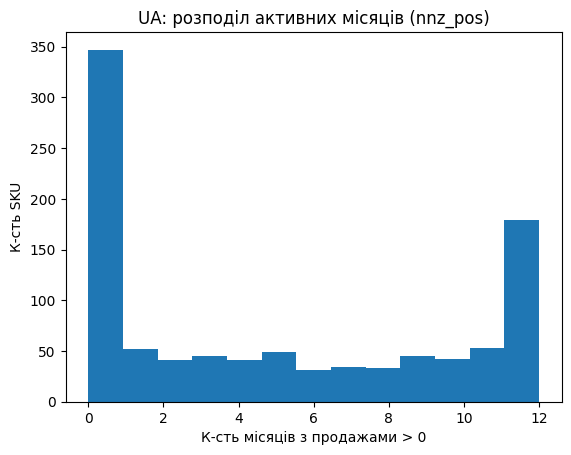

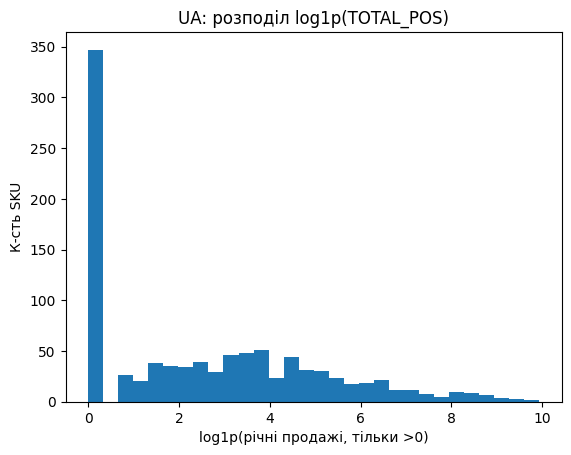

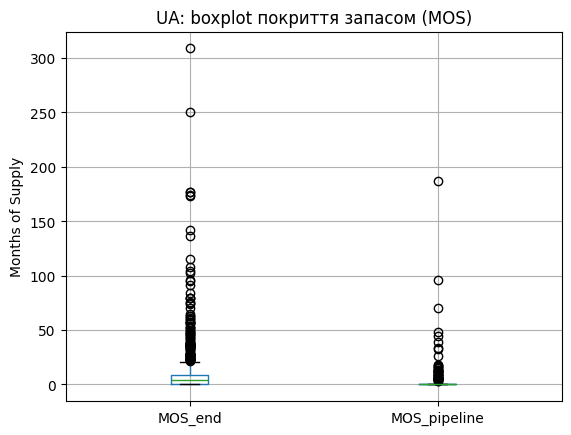

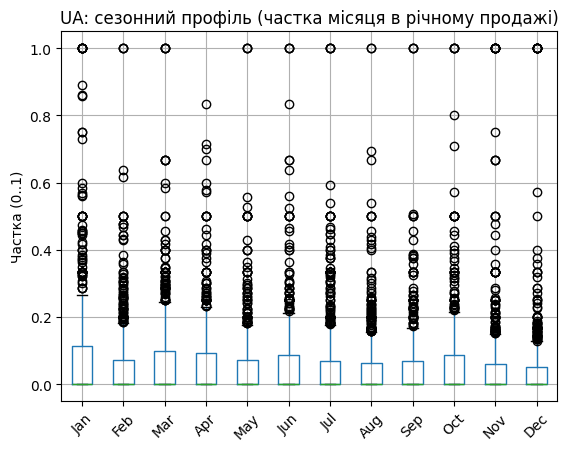

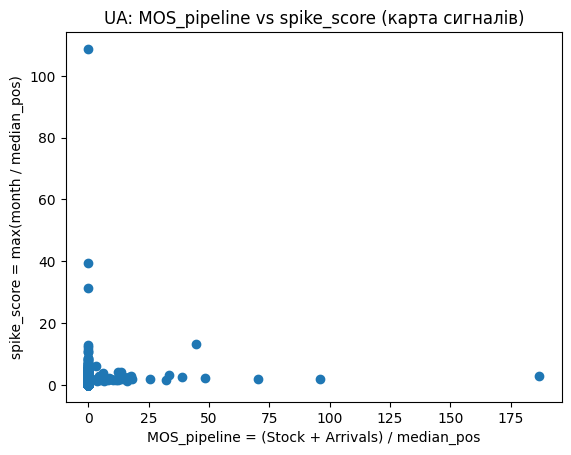

### KZ: короткий підсумок
- SKU у вибірці: **345**
- Сегментація: **Slow**=161, **Fast/Stable**=115, **Regular**=69
- Promo spikes: **14** (поріг spike_score ≥ 5.00; p95=5.00)
- One-off: **9** (поріг TOTAL_POS ≥ 24.00 серед slow)
- Drop-to-zero (Q4=['окт', 'ноя', 'дек']): **5**
- OOS risk (MOS_pipeline < 1.00): **1**
- Overstock risk (MOS_end ≥ 13.20): **12**
- SKU з негативними місяцями (returns/corrections): **13**
- Найчастіші місяці піків серед promo: окт (4), фев (3), янв (3)

[KZ] Top promo spikes


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
1210,JLAD013-G-S-1,Regular,492.0,10,18.0,1.611976,20.0,0.040650,328.0,NaN,янв,264.0,14.666667,Promo / Transfer / Reduce buys
1056,PR-MOS-44-4855-000-SET,Regular,444.0,11,20.0,1.126927,0.0,0.000000,206.0,50.0,май,153.0,7.650000,Investigate promo/campaign
1206,JLAD011-G-S-1,Fast/Stable,184.0,9,8.0,0.975540,20.0,0.108696,136.0,NaN,фев,60.0,7.500000,Promo / Transfer / Reduce buys
1035,PR-LAD-47-2804-000-SET,Regular,167.0,8,10.5,1.103265,0.0,0.000000,113.0,30.0,май,71.0,6.761905,Investigate promo/campaign
1229,JWOL003-G-P-2,Regular,524.0,11,28.0,1.116797,4.0,0.007634,324.0,NaN,фев,188.0,6.714286,Investigate promo/campaign
1213,JLAD014-G-S-1,Regular,576.0,9,40.0,1.248045,12.0,0.020833,316.0,NaN,янв,264.0,6.600000,Investigate promo/campaign
1062,PR-REN-47-3841-000-SET,Regular,38.0,6,2.5,1.128331,0.0,0.000000,62.0,NaN,окт,16.0,6.400000,Promo / Transfer / Reduce buys
1091,PR-WOL-49-5657-100-SET,Regular,54.0,9,4.0,1.213352,0.0,0.000000,51.0,50.0,ноя,24.0,6.000000,Investigate promo/campaign
1063,PR-REN-47-3841-050-SET,Regular,34.0,6,2.5,1.033019,0.0,0.000000,116.0,NaN,окт,15.0,6.000000,Promo / Transfer / Reduce buys
1278,PX-DAE-4A-3538-000,Regular,12.0,6,1.0,1.000000,0.0,0.000000,5.0,2.0,янв,6.0,6.000000,Investigate promo/campaign



[KZ] Top one-off закупки


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
1175,PWOL007-S-0-N,Slow,56.0,1,56.0,inf,0.0,0.0,244.0,100.0,дек,56.0,1.000000,One-off: verify customer/order
1321,PX-REN-4A-3841-050-B,Slow,34.0,2,17.0,1.081457,0.0,0.0,5.0,5.0,июл,30.0,1.764706,One-off: verify customer/order
1320,PX-REN-4A-3841-050-A,Slow,34.0,2,17.0,0.748701,0.0,0.0,5.0,5.0,ноя,26.0,1.529412,One-off: verify customer/order
1096,PCHE033-S-0-N,Slow,32.0,2,16.0,0.707107,0.0,0.0,12.0,8.0,ноя,24.0,1.500000,One-off: verify customer/order
1214,JLAD014-G-S-2,Slow,32.0,2,16.0,0.353553,0.0,0.0,68.0,NaN,ноя,20.0,1.250000,One-off: verify customer/order
1332,PX-REN-4A-3842-050-A,Slow,31.0,2,15.5,1.231734,0.0,0.0,5.0,5.0,ноя,29.0,1.870968,One-off: verify customer/order
1122,PDAE013-S-0-H,Slow,30.0,1,30.0,inf,0.0,0.0,78.0,NaN,мар,30.0,1.000000,One-off: verify customer/order
1097,PCHE034-A-0-N,Slow,24.0,1,24.0,inf,0.0,0.0,12.0,NaN,ноя,24.0,1.000000,One-off: verify customer/order
1333,PX-REN-4A-3842-050-B,Slow,24.0,2,12.0,0.235702,0.0,0.0,5.0,5.0,ноя,14.0,1.166667,One-off: verify customer/order



[KZ] Top OOS risk (next-year)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_pipeline,MOS_end,trailing_zeros,drop_q4_to_zero,action
1059,PR-REN-44-3841-025-SET,Regular,51.0,4,11.0,0.693796,0.0,0.0,3.0,3.0,0.545455,0.272727,1,False,Replenish / Expedite



[KZ] Top Overstock risk


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_end,MOS_pipeline,spike_score,action
1063,PR-REN-47-3841-050-SET,Regular,34.0,6,2.5,1.033019,0.0,0.000000,116.0,NaN,46.400000,0.0,6.000000,Promo / Transfer / Reduce buys
1292,PX-LAD-4A-2805-000,Regular,20.0,6,3.0,0.774597,0.0,0.000000,122.0,NaN,40.666667,0.0,2.000000,Promo / Transfer / Reduce buys
1230,JWOL003-G-S-2,Regular,52.0,5,8.0,0.583298,0.0,0.000000,264.0,NaN,33.000000,0.0,2.500000,Promo / Transfer / Reduce buys
1062,PR-REN-47-3841-000-SET,Regular,38.0,6,2.5,1.128331,0.0,0.000000,62.0,NaN,24.800000,0.0,6.400000,Promo / Transfer / Reduce buys
1210,JLAD013-G-S-1,Regular,492.0,10,18.0,1.611976,20.0,0.040650,328.0,NaN,18.222222,0.0,14.666667,Promo / Transfer / Reduce buys
1174,PWOL004-A-0-N,Fast/Stable,292.0,9,20.0,0.963784,0.0,0.000000,356.0,NaN,17.800000,0.0,5.400000,Promo / Transfer / Reduce buys
1206,JLAD011-G-S-1,Fast/Stable,184.0,9,8.0,0.975540,20.0,0.108696,136.0,NaN,17.000000,0.0,7.500000,Promo / Transfer / Reduce buys
1204,JLAD010-B-S-0,Fast/Stable,1256.0,11,96.0,0.715947,16.0,0.012739,1456.0,NaN,15.166667,0.0,3.083333,Promo / Transfer / Reduce buys
1155,PMOS002-A-0-D,Fast/Stable,72.0,10,4.0,0.731423,0.0,0.000000,56.0,20.0,14.000000,19.0,5.000000,Promo / Transfer / Reduce buys
1235,JWOL004-G-P-2,Fast/Stable,516.0,12,32.0,0.817840,0.0,0.000000,436.0,NaN,13.625000,0.0,4.375000,Promo / Transfer / Reduce buys



[KZ] Top Returns/Corrections


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,has_negative,action
1183,JCHE005-G-S-0,Regular,92.0,6,12.0,0.604332,20.0,0.217391,60.0,40.0,True,Check returns/corrections
1255,XLAD-61-RED,Regular,20.0,3,4.0,0.692820,4.0,0.200000,44.0,NaN,True,Check returns/corrections
1094,PCHE007-S-0-N,Regular,44.0,4,8.0,0.545455,8.0,0.181818,44.0,NaN,True,Check returns/corrections
1206,JLAD011-G-S-1,Fast/Stable,184.0,9,8.0,0.975540,20.0,0.108696,136.0,NaN,True,Promo / Transfer / Reduce buys
1095,PCHE008-A-0-N,Regular,76.0,8,8.0,0.500099,8.0,0.105263,44.0,NaN,True,Check returns/corrections
1208,JLAD012-G-S-1,Fast/Stable,224.0,9,16.0,0.778170,20.0,0.089286,156.0,NaN,True,Check returns/corrections
1267,XWOL-67-GREEN,Regular,284.0,8,30.0,1.013973,20.0,0.070423,200.0,NaN,True,Check returns/corrections
1057,PR-MOS-44-4855-050-SET,Regular,20.0,4,5.0,0.000000,1.0,0.050000,30.0,NaN,True,Check returns/corrections
1210,JLAD013-G-S-1,Regular,492.0,10,18.0,1.611976,20.0,0.040650,328.0,NaN,True,Promo / Transfer / Reduce buys
1213,JLAD014-G-S-1,Regular,576.0,9,40.0,1.248045,12.0,0.020833,316.0,NaN,True,Investigate promo/campaign



[KZ] Top Drop-to-zero (Q4)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,trailing_zeros,drop_q4_to_zero,action
1310,PX-LAD-4A-2818-050-B,Slow,9.0,3,3.0,0.666667,0.0,0.00,4.0,NaN,5,True,No action
1050,PR-LAD-49-2805-075-SET,Slow,6.0,4,1.0,0.666667,0.0,0.00,5.0,NaN,4,True,No action
1046,PR-LAD-48-2805-100-SET,Fast/Stable,502.0,9,57.0,0.618901,0.0,0.00,350.0,350.0,3,True,No action
1284,PX-DAE-4A-3548-025-2,Regular,38.0,4,11.0,0.573338,0.0,0.00,18.0,18.0,3,True,No action
1057,PR-MOS-44-4855-050-SET,Regular,20.0,4,5.0,0.000000,1.0,0.05,30.0,NaN,3,True,Check returns/corrections


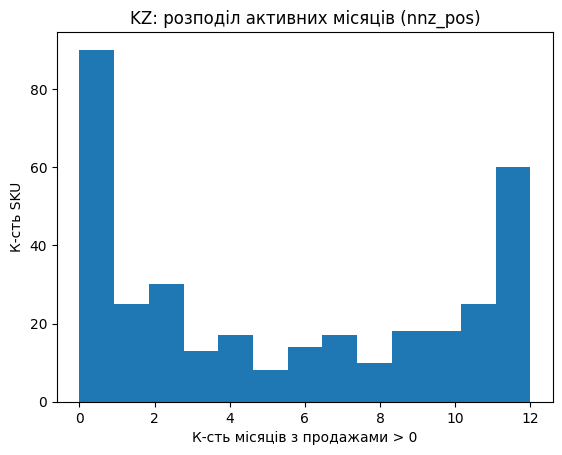

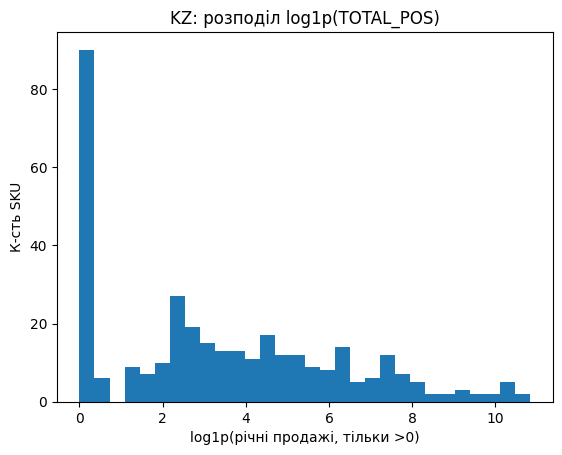

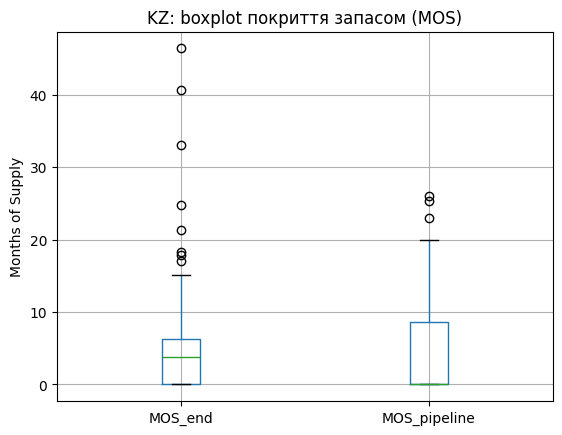

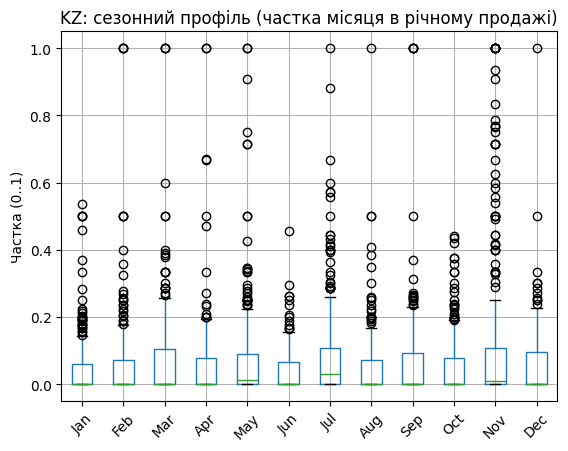

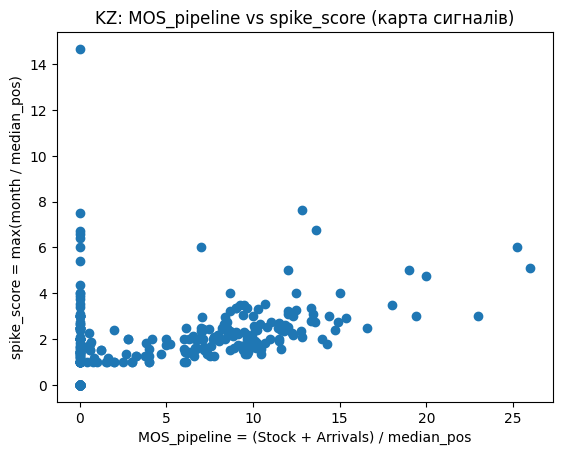

### UZ: короткий підсумок
- SKU у вибірці: **597**
- Сегментація: **Slow**=285, **Regular**=195, **Fast/Stable**=117
- Promo spikes: **25** (поріг spike_score ≥ 8.30; p95=8.30)
- One-off: **14** (поріг TOTAL_POS ≥ 100.00 серед slow)
- Drop-to-zero (Q4=['окт', 'ноя', 'дек']): **40**
- OOS risk (MOS_pipeline < 1.00): **0**
- Overstock risk (MOS_end ≥ 65.80): **20**
- SKU з негативними місяцями (returns/corrections): **26**
- Найчастіші місяці піків серед promo: сен (10), окт (7), апр (4)

[UZ] Top promo spikes


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
1605,JDAE003-G-S-1,Regular,294.0,4,6.0,1.836735,0.0,0.000000,99.0,99.0,авг,276.0,46.000000,Investigate promo/campaign
1511,PCHE008-A-0-N,Regular,264.0,6,10.0,1.871933,56.0,0.212121,620.0,NaN,сен,212.0,21.200000,Investigate promo/campaign
1509,PCHE007-S-0-N,Regular,256.0,6,10.0,1.853944,56.0,0.218750,624.0,NaN,сен,204.0,20.400000,Investigate promo/campaign
1912,TC-5901-025,Regular,172.0,4,8.0,1.690491,0.0,0.000000,244.0,NaN,апр,152.0,19.000000,Investigate promo/campaign
1853,PX-RAV-4A-5902-000,Regular,109.0,9,3.0,1.347570,0.0,0.000000,223.0,NaN,май,44.0,14.666667,Promo / Transfer / Reduce buys
1659,JWOL004-G-S-1,Regular,2612.0,9,68.0,1.164280,0.0,0.000000,680.0,680.0,окт,960.0,14.117647,Investigate promo/campaign
1653,JWOL003-G-S-1,Regular,2600.0,9,68.0,1.149518,0.0,0.000000,680.0,680.0,окт,960.0,14.117647,Investigate promo/campaign
1513,PCHE014-A-0-N,Regular,324.0,4,20.0,1.644958,0.0,0.000000,248.0,NaN,сен,280.0,14.000000,Investigate promo/campaign
1426,PR-LAD-49-2805-100-SET,Regular,134.0,7,5.0,1.251345,0.0,0.000000,105.0,NaN,сен,69.0,13.800000,Investigate promo/campaign
1716,PX-DAE-3A-1401-100,Regular,29.0,8,1.5,1.614862,1.0,0.034483,24.0,NaN,окт,18.0,12.000000,Investigate promo/campaign



[UZ] Top one-off закупки


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,spike_month,spike_value,spike_score,action
1611,JKAM001-G-P-0,Slow,820.0,1,820.0,inf,0.0,0.0,2400.0,NaN,мар,820.0,1.000000,One-off: verify customer/order
1664,JZIL001-G-P-0,Slow,796.0,1,796.0,inf,0.0,0.0,20.0,NaN,сен,796.0,1.000000,One-off: verify customer/order
1670,JZIL002-G-P-0,Slow,796.0,1,796.0,inf,0.0,0.0,20.0,NaN,сен,796.0,1.000000,One-off: verify customer/order
1606,JDAE003-G-S-2,Slow,330.0,2,165.0,0.899954,0.0,0.0,240.0,NaN,июл,270.0,1.636364,One-off: verify customer/order
1600,JCHE005-G-S-1,Slow,240.0,2,120.0,0.471405,0.0,0.0,0.0,NaN,дек,160.0,1.333333,One-off: verify customer/order
1610,JISU003-G-S-0,Slow,240.0,2,120.0,0.942809,0.0,0.0,348.0,NaN,окт,200.0,1.666667,One-off: verify customer/order
1671,JZIL002-G-S-0,Slow,200.0,1,200.0,inf,0.0,0.0,0.0,NaN,фев,200.0,1.000000,One-off: verify customer/order
1665,JZIL001-G-S-0,Slow,200.0,1,200.0,inf,0.0,0.0,100.0,NaN,фев,200.0,1.000000,One-off: verify customer/order
1662,JYAM001-G-P-0,Slow,140.0,1,140.0,inf,0.0,0.0,0.0,NaN,сен,140.0,1.000000,One-off: verify customer/order
1930,D162,Slow,128.0,2,64.0,1.325825,0.0,0.0,376.0,NaN,июл,124.0,1.937500,One-off: verify customer/order



[UZ] Top OOS risk (next-year)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_pipeline,MOS_end,trailing_zeros,drop_q4_to_zero,action



[UZ] Top Overstock risk


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,MOS_end,MOS_pipeline,spike_score,action
1732,PX-DAE-4A-3548-050,Regular,21.0,7,1.0,1.276569,0.0,0.000000,414.0,NaN,414.000000,0.0,11.000000,Promo / Transfer / Reduce buys
1491,PR-WOL-44-5656-000-SET,Regular,18.0,6,2.5,0.557773,0.0,0.000000,810.0,NaN,324.000000,0.0,2.000000,Promo / Transfer / Reduce buys
1896,TC-3538-025,Regular,36.0,5,4.0,0.724356,12.0,0.333333,975.0,NaN,243.750000,0.0,4.000000,Promo / Transfer / Reduce buys
1354,PR-DAE-37-1401-075-SET,Regular,39.0,10,2.0,1.090874,0.0,0.000000,392.0,NaN,196.000000,0.0,6.500000,Promo / Transfer / Reduce buys
1745,PX-DAE-4F-3548-050-2,Regular,11.0,3,4.0,0.686349,0.0,0.000000,691.0,NaN,172.750000,0.0,1.500000,Promo / Transfer / Reduce buys
1895,TC-3538-000,Fast/Stable,404.0,10,24.0,0.992791,0.0,0.000000,3568.0,NaN,148.666667,0.0,5.333333,Promo / Transfer / Reduce buys
1899,TC-3548-000,Regular,540.0,11,28.0,1.080416,0.0,0.000000,3820.0,NaN,136.428571,0.0,6.000000,Promo / Transfer / Reduce buys
1903,TC-3549-000,Regular,224.0,8,14.0,1.254729,0.0,0.000000,1840.0,NaN,131.428571,0.0,8.000000,Promo / Transfer / Reduce buys
1409,PR-LAD-49-2803-100-SET,Regular,15.0,6,2.0,0.748331,0.0,0.000000,250.0,NaN,125.000000,0.0,3.000000,Promo / Transfer / Reduce buys
1656,JWOL004-G-P-0,Regular,24.0,3,8.0,0.000000,0.0,0.000000,916.0,NaN,114.500000,0.0,1.000000,Promo / Transfer / Reduce buys



[UZ] Top Returns/Corrections


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,has_negative,action
1538,PISU033-S-0-N,Slow,12.0,2,6.0,0.471405,8.0,0.666667,44.0,NaN,True,Check returns/corrections
1539,PISU034-B-0-N,Slow,12.0,2,6.0,0.471405,8.0,0.666667,44.0,NaN,True,Check returns/corrections
1546,PLAD003-S-0-D,Regular,68.0,3,20.0,0.713197,40.0,0.588235,72.0,NaN,True,Check returns/corrections
1775,PX-LAD-4A-2803-070,Slow,2.0,1,2.0,inf,1.0,0.500000,0.0,NaN,True,Check returns/corrections
1531,PDAE011-S-0-N,Regular,108.0,4,22.0,0.644345,52.0,0.481481,200.0,NaN,True,Check returns/corrections
1371,PR-DAE-49-1402-100-SET,Regular,11.0,3,5.0,0.629837,5.0,0.454545,5.0,NaN,True,Check returns/corrections
1896,TC-3538-025,Regular,36.0,5,4.0,0.724356,12.0,0.333333,975.0,NaN,True,Promo / Transfer / Reduce buys
1523,PDAE003-S-0-N,Fast/Stable,220.0,9,16.0,0.799328,72.0,0.327273,92.0,NaN,True,Check returns/corrections
1525,PDAE004-A-0-N,Fast/Stable,220.0,9,16.0,0.799328,72.0,0.327273,108.0,100.0,True,Check returns/corrections
1509,PCHE007-S-0-N,Regular,256.0,6,10.0,1.853944,56.0,0.218750,624.0,NaN,True,Investigate promo/campaign



[UZ] Top Drop-to-zero (Q4)


,SKU,Segment,TOTAL_POS,nnz_pos,median_pos,cv_pos,TOTAL_RET,ret_rate,Stock,Arrivals_added,trailing_zeros,drop_q4_to_zero,action
1765,PX-LAD-4A-2803-000,Regular,20.0,4,3.0,0.938083,0.0,0.000000,0.0,NaN,8,True,No action
1429,PR-LAD-48-2806-100-SET,Slow,9.0,3,3.0,0.333333,0.0,0.000000,20.0,NaN,7,True,No action
1769,PX-LAD-4A-2803-000-2-D,Slow,9.0,4,2.0,0.559247,0.0,0.000000,0.0,NaN,7,True,No action
1546,PLAD003-S-0-D,Regular,68.0,3,20.0,0.713197,40.0,0.588235,72.0,NaN,6,True,Check returns/corrections
1454,PR-REN-49-3841-000-SET,Regular,26.0,5,5.0,0.737319,0.0,0.000000,25.0,NaN,5,True,No action
1819,PX-LAD-4A-2808-040-E,Slow,5.0,3,1.0,0.692820,0.0,0.000000,5.0,NaN,5,True,No action
1497,PR-WOL-44-5657-000-SET,Regular,20.0,5,4.0,0.684653,0.0,0.000000,18.0,NaN,4,True,No action
1442,PR-RAV-47-5901-050-SET,Regular,10.0,4,2.0,0.400000,0.0,0.000000,12.0,NaN,4,True,No action
1613,JLAD001-G-S-0,Fast/Stable,6080.0,9,728.0,0.519608,0.0,0.000000,0.0,NaN,3,True,No action
1616,JLAD004-G-S-0,Fast/Stable,1888.0,9,232.0,0.369014,0.0,0.000000,0.0,NaN,3,True,No action


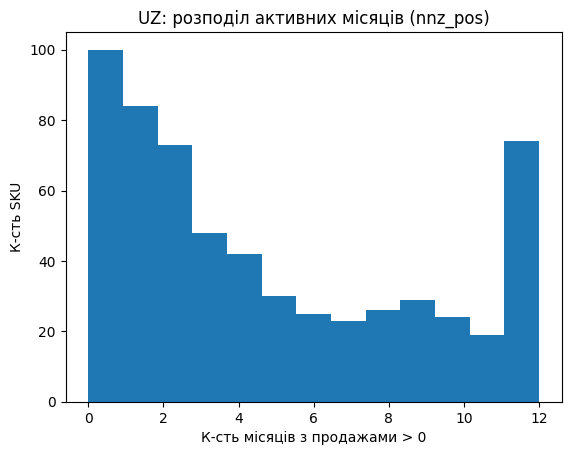

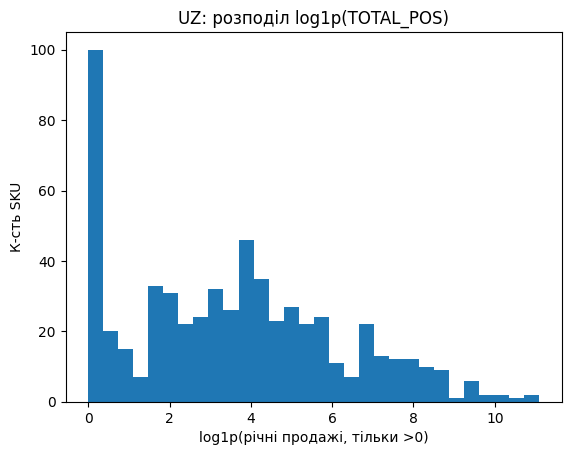

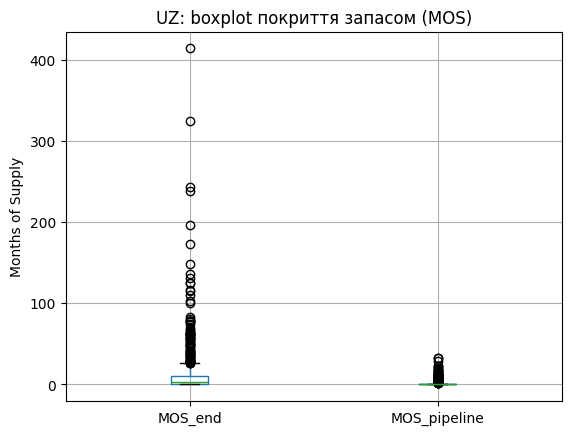

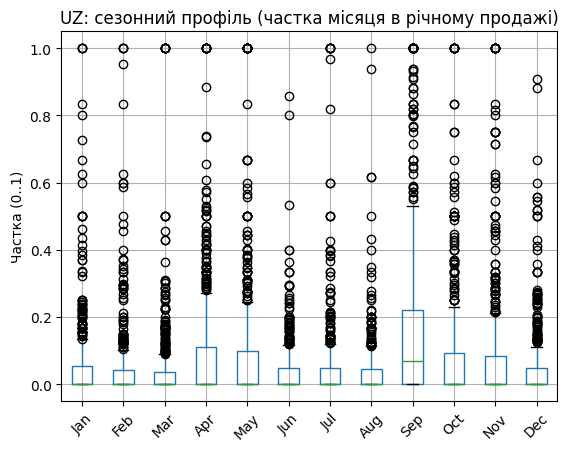

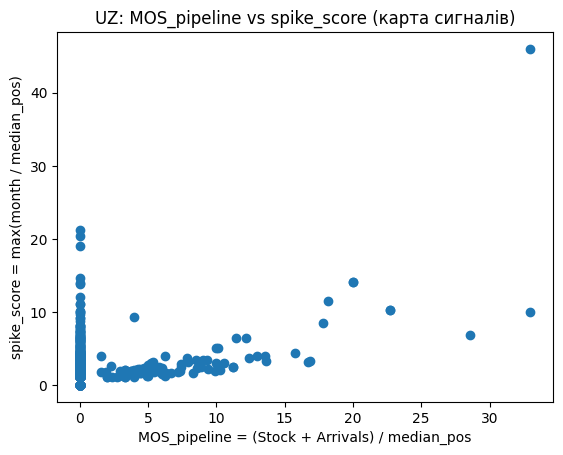

Saved: diploma_decision_support_report.xlsx


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ==== з конфіга (як ти написав) ====
MONTHS_CFG = ["янв","фев","мар","апр","май","июн","июл","авг","сен","окт","ноя","дек"]
REGIONS_CFG = ["UA", "KZ", "UZ"]

# (опційно) красиві підписи місяців для графіків
MONTH_LABELS = {
    "янв":"Jan","фев":"Feb","мар":"Mar","апр":"Apr","май":"May","июн":"Jun",
    "июл":"Jul","авг":"Aug","сен":"Sep","окт":"Oct","ноя":"Nov","дек":"Dec"
}

# ============================================================
# 0) Перевірки і "robust" визначення місячних колонок
# ============================================================
assert "Region" in df_all.columns, "df_all не знайдено або немає колонки Region"
assert "Arrivals_added" in df_all.columns, "Немає колонки Arrivals_added"
assert "TOTAL_NET" in df_all.columns, "Немає колонки TOTAL_NET (використовується як маркер межі місяців)"

def detect_months(df: pd.DataFrame, months_cfg: list[str]) -> list[str]:
    """Повертає список місячних колонок: або з конфіга (якщо є), або авто по позиції."""
    if all(m in df.columns for m in months_cfg):
        return months_cfg

    # fallback: авто визначення по позиції між Arrivals_added і TOTAL_NET
    cols = list(df.columns)
    i0 = cols.index("Arrivals_added") + 1
    i1 = cols.index("TOTAL_NET")
    months_auto = cols[i0:i1]

    # sanity checks
    if len(months_auto) != 12:
        print("⚠️ Не вийшло детектити 12 місяців автоматично. Знайдено:", months_auto)
    return months_auto

MONTHS = detect_months(df_all, MONTHS_CFG)
print("Using MONTHS:", MONTHS)

# ============================================================
# 1) Core helpers
# ============================================================

def _safe_quantile(s, q, default=np.nan):
    s = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) == 0:
        return default
    return float(s.quantile(q))

def add_decision_features(df_region: pd.DataFrame, months: list[str]) -> tuple[pd.DataFrame, dict]:
    """
    Додає скоринг/флаги для decision-support (per-region).
    Патчі:
      - safe idxmax (без FutureWarning)
      - spike_month = NA для SKU без позитивних продажів
      - Q4 визначається як останні 3 місяці зі списку months
      - region-specific thresholds через перцентилі, але на релевантних підмножинах
    Очікує наявність колонок: median_pos, nnz_pos, TOTAL_POS, TOTAL_RET, ret_rate, Stock, Arrivals_added.
    """
    df = df_region.copy()

    # ---- 1) Позитивні продажі (попит) ----
    pos = df[months].clip(lower=0)

    # ---- 2) Spike score: max(month / median_pos) ----
    denom = df["median_pos"].replace(0, np.nan)
    ratio = pos.div(denom, axis=0).replace([np.inf, -np.inf], np.nan)

    # spike_score: якщо median_pos==0 -> всі NA -> spike_score=0
    df["spike_score"] = ratio.max(axis=1, skipna=True).fillna(0.0)

    # safe spike_month (без warning)
    # для all-NA рядків fill(-inf) дозволяє idxmax, але ми потім виставимо NA якщо spike_score==0
    ratio_filled = ratio.fillna(-np.inf)
    spike_month = ratio_filled.idxmax(axis=1)
    spike_month = spike_month.where(df["spike_score"] > 0, other=pd.NA)
    df["spike_month"] = spike_month

    # spike_value: максимум позитивних продажів (0 якщо не було продажів)
    df["spike_value"] = pos.max(axis=1).fillna(0.0)

    # ---- 3) Trailing zeros: скільки місяців підряд = 0 з кінця року ----
    rev = pos.iloc[:, ::-1]
    df["trailing_zeros"] = rev.eq(0).cumprod(axis=1).sum(axis=1)

    # ---- 4) Drop-to-zero в Q4 (останні 3 місяці) після активності раніше ----
    q4 = months[-3:]
    df["drop_q4_to_zero"] = (
        (df["nnz_pos"] >= 3)
        & (pos[q4].eq(0).all(axis=1))
        & (pos[months[:-3]].sum(axis=1) > 0)
    )

    # ---- 5) MOS (Months of Supply) ----
    # Якщо median_pos==0 -> MOS не визначений -> 0 (бо ризики дефіциту/оверстоку без попиту не мають сенсу)
    df["MOS_end"] = (df["Stock"] / denom).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    df["MOS_pipeline"] = ((df["Stock"] + df["Arrivals_added"]) / denom).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # ---- 6) Returns/corrections flag ----
    df["has_negative"] = (df[months] < 0).any(axis=1)

    # ============================================================
    # 7) Region-specific thresholds (перцентилі)
    # ============================================================

    # Promo spike threshold: base 5x, plus p95 spike_score but only where defined (median_pos>0)
    spike_pool = df.loc[df["median_pos"] > 0, "spike_score"]
    spike_p95 = _safe_quantile(spike_pool, 0.95, default=5.0)
    spike_thr = max(5.0, spike_p95)

    # One-off threshold: p95 TOTAL_POS серед slow movers (nnz<=2), fallback на весь регіон
    slow = df[df["nnz_pos"] <= 2]
    oneoff_p95_slow = _safe_quantile(slow["TOTAL_POS"], 0.95, default=np.nan)
    if np.isnan(oneoff_p95_slow):
        oneoff_p95_slow = _safe_quantile(df["TOTAL_POS"], 0.95, default=0.0)
    oneoff_thr = oneoff_p95_slow

    # Overstock threshold: MOS_end > 6 або p95 (що більше), але MOS має сенс лише там де median_pos>0
    mos_pool = df.loc[df["median_pos"] > 0, "MOS_end"]
    mos_p95 = _safe_quantile(mos_pool, 0.95, default=6.0)
    overstock_thr = max(6.0, mos_p95)

    # OOS risk threshold (універсально)
    oos_thr = 1.0

    # ============================================================
    # 8) Flags + action (простий rule-based)
    # ============================================================

    df["promo_spike"] = (df["nnz_pos"] >= 3) & (df["spike_score"] >= spike_thr)

    df["one_off"] = (df["nnz_pos"] <= 2) & (df["TOTAL_POS"] >= oneoff_thr)

    # ризик дефіциту на старт року має сенс лише якщо був попит (median_pos>0) і pipeline > 0
    df["risk_nextyear_oos"] = (
        (df["nnz_pos"] >= 3)
        & (df["median_pos"] > 0)
        & (df["MOS_pipeline"] > 0)
        & (df["MOS_pipeline"] < oos_thr)
    )

    # overstock має сенс лише якщо був попит (median_pos>0)
    df["risk_overstock"] = (
        (df["nnz_pos"] >= 3)
        & (df["median_pos"] > 0)
        & (df["MOS_end"] >= overstock_thr)
    )

    def _action(row):
        # Пріоритети: OOS > Overstock > Promo > One-off > Returns
        if row["risk_nextyear_oos"]:
            return "Replenish / Expedite"
        if row["risk_overstock"]:
            return "Promo / Transfer / Reduce buys"
        if row["promo_spike"]:
            return "Investigate promo/campaign"
        if row["one_off"]:
            return "One-off: verify customer/order"
        if row["has_negative"] or (row.get("ret_rate", 0) >= 0.3):
            return "Check returns/corrections"
        return "No action"

    df["action"] = df.apply(_action, axis=1)

    thresholds = {
        "months": months,
        "q4": q4,
        "spike_thr": spike_thr,
        "spike_p95": spike_p95,
        "oneoff_thr_totalpos_p95_slow": oneoff_thr,
        "overstock_thr_mos": overstock_thr,
        "oos_thr_mos_pipeline": oos_thr,
    }

    return df, thresholds

def make_top_tables(df_region_feat: pd.DataFrame, months: list[str], n=15) -> dict:
    df = df_region_feat.copy()
    cols_base = ["SKU","Segment","TOTAL_POS","nnz_pos","median_pos","cv_pos","TOTAL_RET","ret_rate","Stock","Arrivals_added"]

    # Promo spikes
    t_promo = df[df["promo_spike"]].sort_values(["spike_score","TOTAL_POS"], ascending=False)
    t_promo = t_promo[cols_base + ["spike_month","spike_value","spike_score","action"]].head(n)

    # One-off
    t_oneoff = df[df["one_off"]].sort_values(["TOTAL_POS"], ascending=False)
    t_oneoff = t_oneoff[cols_base + ["spike_month","spike_value","spike_score","action"]].head(n)

    # OOS risk
    t_oos = df[df["risk_nextyear_oos"]].sort_values(["MOS_pipeline","TOTAL_POS"], ascending=[True, False])
    t_oos = t_oos[cols_base + ["MOS_pipeline","MOS_end","trailing_zeros","drop_q4_to_zero","action"]].head(n)

    # Overstock
    t_over = df[df["risk_overstock"]].sort_values(["MOS_end","Stock"], ascending=False)
    t_over = t_over[cols_base + ["MOS_end","MOS_pipeline","spike_score","action"]].head(n)

    # Returns/corrections
    t_ret = df.sort_values(["ret_rate","TOTAL_RET"], ascending=False)
    t_ret = t_ret[cols_base + ["has_negative","action"]].head(n)

    # Drop-to-zero (Q4)
    t_drop = df[df["drop_q4_to_zero"]].sort_values(["trailing_zeros","TOTAL_POS"], ascending=False)
    t_drop = t_drop[cols_base + ["trailing_zeros","drop_q4_to_zero","action"]].head(n)

    return {
        "Top promo spikes": t_promo,
        "Top one-off закупки": t_oneoff,
        "Top OOS risk (next-year)": t_oos,
        "Top Overstock risk": t_over,
        "Top Returns/Corrections": t_ret,
        "Top Drop-to-zero (Q4)": t_drop,
    }

def plot_region_figures(df_region_feat: pd.DataFrame, region_name: str, months: list[str]):
    df = df_region_feat.copy()

    # 1) nnz_pos histogram
    plt.figure()
    df["nnz_pos"].plot.hist(bins=13)
    plt.title(f"{region_name}: розподіл активних місяців (nnz_pos)")
    plt.xlabel("К-сть місяців з продажами > 0")
    plt.ylabel("К-сть SKU")
    plt.show()

    # 2) log1p(TOTAL_POS) histogram
    plt.figure()
    np.log1p(df["TOTAL_POS"]).plot.hist(bins=30)
    plt.title(f"{region_name}: розподіл log1p(TOTAL_POS)")
    plt.xlabel("log1p(річні продажі, тільки >0)")
    plt.ylabel("К-сть SKU")
    plt.show()

    # 3) MOS boxplot
    plt.figure()
    df[["MOS_end","MOS_pipeline"]].boxplot()
    plt.title(f"{region_name}: boxplot покриття запасом (MOS)")
    plt.ylabel("Months of Supply")
    plt.show()

    # 4) Seasonality boxplot (share)
    pos = df[months].clip(lower=0)
    total = pos.sum(axis=1).replace(0, np.nan)
    share = pos.div(total, axis=0).fillna(0)
    share = share.rename(columns=MONTH_LABELS)

    plt.figure()
    share.boxplot(rot=45)
    plt.title(f"{region_name}: сезонний профіль (частка місяця в річному продажі)")
    plt.ylabel("Частка (0..1)")
    plt.show()

    # 5) Scatter: MOS_pipeline vs spike_score
    plt.figure()
    plt.scatter(df["MOS_pipeline"], df["spike_score"])
    plt.title(f"{region_name}: MOS_pipeline vs spike_score (карта сигналів)")
    plt.xlabel("MOS_pipeline = (Stock + Arrivals) / median_pos")
    plt.ylabel("spike_score = max(month / median_pos)")
    plt.show()

def region_summary(df_region_feat: pd.DataFrame, region: str, thresholds: dict) -> str:
    df = df_region_feat

    seg = df["Segment"].value_counts(dropna=False)
    n_total = len(df)

    n_promo = int(df["promo_spike"].sum())
    n_oneoff = int(df["one_off"].sum())
    n_drop = int(df["drop_q4_to_zero"].sum())
    n_oos = int(df["risk_nextyear_oos"].sum())
    n_over = int(df["risk_overstock"].sum())
    n_neg = int(df["has_negative"].sum())

    promo_months = df.loc[df["promo_spike"], "spike_month"].value_counts().head(3)

    lines = []
    lines.append(f"### {region}: короткий підсумок")
    lines.append(f"- SKU у вибірці: **{n_total}**")
    lines.append("- Сегментація: " + ", ".join([f"**{k}**={int(v)}" for k,v in seg.items()]))
    lines.append(f"- Promo spikes: **{n_promo}** (поріг spike_score ≥ {thresholds['spike_thr']:.2f}; p95={thresholds['spike_p95']:.2f})")
    lines.append(f"- One-off: **{n_oneoff}** (поріг TOTAL_POS ≥ {thresholds['oneoff_thr_totalpos_p95_slow']:.2f} серед slow)")
    lines.append(f"- Drop-to-zero (Q4={thresholds['q4']}): **{n_drop}**")
    lines.append(f"- OOS risk (MOS_pipeline < {thresholds['oos_thr_mos_pipeline']:.2f}): **{n_oos}**")
    lines.append(f"- Overstock risk (MOS_end ≥ {thresholds['overstock_thr_mos']:.2f}): **{n_over}**")
    lines.append(f"- SKU з негативними місяцями (returns/corrections): **{n_neg}**")

    if len(promo_months) > 0:
        topm = ", ".join([f"{m} ({c})" for m,c in promo_months.items()])
        lines.append(f"- Найчастіші місяці піків серед promo: {topm}")

    return "\n".join(lines)

# ============================================================
# 2) RUN PIPELINE ПО 3 РЕГІОНАХ
# ============================================================
df_feat_all = []
thresholds_by_region = {}

# якщо в df_all є якісь інші регіони — беремо перетин з конфігом
regions_present = sorted(df_all["Region"].unique())
regions_run = [r for r in REGIONS_CFG if r in regions_present] or regions_present

for region in regions_run:
    df_r = df_all[df_all["Region"] == region].copy()
    df_r_feat, thr = add_decision_features(df_r, months=MONTHS)
    df_feat_all.append(df_r_feat)
    thresholds_by_region[region] = thr

df_feat_all = pd.concat(df_feat_all, ignore_index=True)

# ============================================================
# 3) OUTPUT: висновки + таблиці + графіки
# ============================================================
for region in regions_run:
    print("="*90)
    print(region_summary(df_feat_all[df_feat_all["Region"] == region], region, thresholds_by_region[region]))
    print("="*90)

    tables = make_top_tables(df_feat_all[df_feat_all["Region"] == region], months=MONTHS, n=15)
    for title, tbl in tables.items():
        print(f"\n[{region}] {title}")
        display(tbl)

    plot_region_figures(df_feat_all[df_feat_all["Region"] == region], region_name=region, months=MONTHS)

# ============================================================
# 4) OPTIONAL: export в Excel
# ============================================================
out_path = "diploma_decision_support_report.xlsx"
with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    df_feat_all.to_excel(writer, sheet_name="all_regions_features", index=False)
    for region in regions_run:
        tables = make_top_tables(df_feat_all[df_feat_all["Region"] == region], months=MONTHS, n=30)
        for title, tbl in tables.items():
            safe_name = (f"{region} - {title}")[:31].replace("/", "-")
            tbl.to_excel(writer, sheet_name=safe_name, index=False)

print("Saved:", out_path)
